<a id="top" style="float:right;" href="http://dynfluid.ensam.eu/"><img style="height:120px;" src="http://dynfluid.ensam.eu/uas/DYNFLUID/logoPrincipal/Logo-DynFluid-Web.png"/></a>
<a style="float:left;" href="http://www.cnam.fr//"><img style="height:120px;" src="https://upload.wikimedia.org/wikipedia/commons/4/45/Logo_ENSTA_Paris.jpg"></a>

<center>
<h3 style="color:#888888;"> <i>--  Introduction à la méthode de Boltzmann sur Réseau  --</i> </h3>
<h1> Projet LBM </h1>
<h3> Etude de l'écoulement afleurant une marche descendante</h3>

<h6><a href="mailto:simon.marie@lecnam.net">simon.marie@lecnam.net</a></h6>
</center>

<h1> Préambule </h1>

Le projet doit être rendu sous la forme d'un Notebook jupyter en respectant la nomenclature suivante:
<center>
<b>Projet_NOM1_NOM2.ipynb</b>
</center>

Tous les résultats, discussions, analyses, doivent donc être inclus dans le fichier.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import os

fs=20
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)
%matplotlib inline

colors = mpl.colormaps['tab10'].colors

<h1>Présentation du Projet</h1>

On se propose dans ce projet d'étudier l'écoulement affleurant une marche descendante à l'aide d'un code Lattice Boltzmann utilisant le modèle $D2Q9$ présenté et utilisé dans les précédents TP.


<h2>La marche descendante</h2>

L'écoulement affleurant une marche descendante consiste à injecter un profil de vitesse le long d'un canal de hauteur $H$ borné par des parois solides et débouchant, à partir d'une longueur $L$, sur une marche de hauteur $h$. Le rapport d'aspect $Ar=\frac{H+h}{h}$ est fixé ici à 2 (Donc $H=h$). La sortie du domaine sera traitée en condition de Neumann en imposant un gradient nul pour les fonctions de distributions.

Le domaine de calcul utilisé est présenté sur la figure 1: 

<center>
<img src="https://hpp.education/Lessons/LBM/ENSTA/BFS.png" style="width:900px;"/> 
    <b><i>Figure 1: Géométrie du domaine de calcul</i></b>
</center>

Le nombre de Reynolds de cet écoulement est basé sur la hauteur totale $2H$ du domaine:
$$
Re=\dfrac{U_0 2H}{\nu}
$$

La vitesse $U_0$ est fixée ici pour avoir $M_0=\frac{U_0}{c_0}=0.3$ et le profil de vitesse en entrée est donné par:

$$
U(r)=U_0\left(1-\dfrac{r^n}{R^n} \right)
$$

Ou $r$ représente la distance au centre du canal initial et $R=H/2$. On prendra dans un premier temps $n=2$ pour avoir un profil laminaire.

Les coordonneés généralisés associés à cette géométrie sont définis par:

$$
X,Y=\dfrac{x-x_0}{H},\dfrac{y-y_0}{H}
$$

avec $(x_0,y_0)=(L,H)$

# Algorithme de calcul

Pour les paramètres du calcul, on définira tout le domaine à partir de la hauteur de marche $H$. On prendra un domaine $(L_x, L_y)=(15H,2H)$ et la longueur du canal initial sera fixée à $L=2H$.

In [15]:
c0=1./np.sqrt(3.)
# Vitesse du son réelle à 293K:
c0_real=np.sqrt(1.4*287*293)

# Maillage/Domaine
H=21        # Nombre de points dans la Hauteur de la Marche
L=2*H         # Longueur incidente
x0,y0=L,H     # Coordonnées du bord de la marche
nx=30*H
ny=2*H
dx = 1./H
dt=dx*c0 / c0_real

In [44]:
ca=np.array([[0,0],[1,0],[0,1],[-1,0],[0,-1],[1,1],[-1,1],[-1,-1],[1,-1]])
w=[4./9.,1./9.,1./9.,1./9.,1./9.,1./36.,1./36.,1./36.,1./36.]


# Puissance dans le profil de vitesse
# n = 2 : laminaire
# n = 8 : turbulent
n = 2

# Mach:
M0=0.3
U0 = M0 * c0

def inlet_profile():
    # Hydraulic radius
    R = int((ny - y0)/2)
    r = np.fromfunction(lambda i: np.abs(R - i), (ny - y0,))
    return U0*(1 - (r**n)/(R**n))

def init(Re, initial_conditions=None):
    geq = np.zeros((nx, ny, 9))

    # C'est mieux d'initialiser un domaine uniforme, que le cylindre vient perturber d'un coup
    rho, ux, uy = np.ones((nx, ny)), np.zeros((nx, ny)), np.zeros((nx, ny))
    ux[:, y0:] = inlet_profile()

    if initial_conditions is not None:
        ux_init, uy_init, rho_init = initial_conditions
        rho[:, :] = rho_init[:, :]
        ux[:, :] = ux_init[:, :]
        uy[:, :] = uy_init[:, :]

    # Vitesse U0 sur tout le domaine
    eq(geq, rho, ux, uy)

    # Dimension caractéristique de l'écoulement = la hauteur de la marche (bulle de recirculation)
    taug = 1/2 + 3 * (U0 * L)/ Re

    return geq,rho,ux,uy,taug

def eq(geq, rho, ux, uy):
    # Mise à jour de geq
    norm = ux[:, :]**2 + uy[:, :]**2

    geq[:, :, 0] = rho[:, :] * w[0] * (1. - 3./2. * norm)
    geq[:, :, 1] = rho[:, :] * w[1] * (1. + 3.*ux[:, :] + 9./2. * ux[:, :]**2 - 3./2. * norm)
    geq[:, :, 2] = rho[:, :] * w[2] * (1. + 3.*uy[:, :] + 9./2. * uy[:, :]**2 - 3./2. * norm)
    geq[:, :, 3] = rho[:, :] * w[3] * (1. - 3.*ux[:, :] + 9./2. * (- ux[:, :])**2 - 3./2. * norm)
    geq[:, :, 4] = rho[:, :] * w[4] * (1. - 3.*uy[:, :] + 9./2. * (- uy[:, :])**2 - 3./2. * norm)
    geq[:, :, 5] = rho[:, :] * w[5] * (1. + 3.*ux[:, :] + 3*uy[:, :] + 9./2. * (+ ux[:, :] + uy[:, :])**2 - 3./2. * norm)
    geq[:, :, 6] = rho[:, :] * w[6] * (1. - 3.*ux[:, :] + 3*uy[:, :] + 9./2. * (- ux[:, :] + uy[:, :])**2 - 3./2. * norm)
    geq[:, :, 7] = rho[:, :] * w[7] * (1. - 3.*ux[:, :] - 3*uy[:, :] + 9./2. * (- ux[:, :] - uy[:, :])**2 - 3./2. * norm)
    geq[:, :, 8] = rho[:, :] * w[8] * (1. + 3.*ux[:, :] - 3*uy[:, :] + 9./2. * (+ ux[:, :] - uy[:, :])**2 - 3./2. * norm)

def collide(g, gcoll, geq, taug):
    # Etape de collision
    gcoll[:, :, :] = g[:, :, :] - (1./taug) * (g[:,:,:] - geq[:,:,:])

def propagate(g, gcoll):
    # Etape de propagation
    # Réalisé dans tout le domaine rectangulaire (la marche sera rectifiée après, cela permet de ne pas surcharger le code avec des indices et des masques)
    g[:, :, 0] = gcoll[:, :,0]
    g[1:, :, 1] = gcoll[:-1, :, 1]
    g[:, 1:, 2] = gcoll[:, :-1, 2]
    g[:-1, :, 3] = gcoll[1:, :, 3]
    g[:, :-1, 4] = gcoll[:, 1:, 4]
    g[1:, 1:, 5] = gcoll[:-1, :-1, 5]
    g[:-1, 1:, 6] = gcoll[1:, :-1, 6]
    g[:-1, :-1, 7] = gcoll[1:, 1:, 7]
    g[1:, :-1, 8] = gcoll[:-1, 1:, 8]

def macro(g, rho, ux, uy):
    # calcul des variables macro
    rho[:,:] = np.sum(g, axis=-1)
    ux[:,:] = (g[:, :, 1] - g[:, :, 3] + g[:, :, 5] - g[:, :, 6] - g[:, :, 7] + g[:, :, 8]) / rho[:,:]
    uy[:,:] = (g[:, :, 2] - g[:, :, 4] + g[:, :, 5] + g[:, :, 6] - g[:, :, 7] - g[:, :, 8]) / rho[:,:]

def wall_noslip(g, gcoll, mask):
    # Bounce back avec frottement
    g[mask == 1, 1] = gcoll[mask == 1, 3]
    g[mask == 1, 2] = gcoll[mask == 1, 4]
    g[mask == 1, 3] = gcoll[mask == 1, 1]
    g[mask == 1, 4] = gcoll[mask == 1, 2]
    g[mask == 1, 5] = gcoll[mask == 1, 7]
    g[mask == 1, 6] = gcoll[mask == 1, 8]
    g[mask == 1, 7] = gcoll[mask == 1, 5]
    g[mask == 1, 8] = gcoll[mask == 1, 6]

def step(g):
    # Rectification des conditions limite sur la marche ; on indice jusqu'à x0+1 et y0+1 pour également inclure le coin de la marche situé en (x0, y0)
    g[:(x0+1), :(y0+1), 1] = g[:(x0+1), :(y0+1), 3]
    g[:(x0+1), :(y0+1), 5] = g[:(x0+1), :(y0+1), 7]
    g[:(x0+1), :(y0+1), 6] = g[:(x0+1), :(y0+1), 8]
    g[:(x0+1), :(y0+1), 8] = g[:(x0+1), :(y0+1), 6]
    g[:(x0+1), :(y0+1), 2] = g[:(x0+1), :(y0+1), 4]

def inflow(g, ux, uy, rho):
    # Conditions de vitesse au bord gauche ; entrée de vitesse

    # ux est bien nul sur H et nx-1, qui sont les bords solides
    ux[0, y0:] = inlet_profile()
    uy[0, y0:] = 0

    rho[0, y0:] = 1/(1 - ux[0, y0:]) * (g[0, y0:, 0] + g[0, y0:, 2] + g[0, y0:, 4] + 2*(g[0, y0:, 3] + g[0, y0:, 6] + g[0, y0:, 7]))

    # Distributions : On impose les distributions inconnues avec le Bounce-Back hors equilibre
    g[0, y0:, 1] = g[0, y0:, 3] + 6*w[1] * rho[0, y0:] * ux[0, y0:]
    g[0, y0:, 5] = g[0, y0:, 7] + 6*w[5] * rho[0, y0:] * (ux[0, y0:] + uy[0, y0:])
    g[0, y0:, 8] = g[0, y0:, 6] + 6*w[8] * rho[0, y0:] * (ux[0, y0:] - uy[0, y0:])

def outflow(g):
    # Conditions de gradient nul sur le bord libre à droite
    # Out -> normale = ex
    g[-1, :, 3] = g[-2, :, 3]
    g[-1, :, 6] = g[-2, :, 6]
    g[-1, :, 7] = g[-2, :, 7]

def simulate(Re, nt=5000, initial_conditions=None, save_results=False, save_interval=500, results_prefix=''):
    total_prefix = results_prefix + ("" if results_prefix == "" else "-")

    # Marquage des conditions aux limites:
    # Fluide: mask=0
    # Solide: mask=1
    mask=np.zeros((nx,ny))
    mask[:, 0] = 1
    mask[:, -1] = 1

    geq,rho,ux,uy,taug=init(Re, initial_conditions=initial_conditions)
    g,gcoll=geq.copy(),geq.copy()

    start=time.time()
    Lr_t = np.zeros(nt)
    max_p_t = np.zeros(nt)

    print(f'''-------------------------------------------------------------------------------------------
PROCESSING NEW SIMULATION

🌊 Re = {Re}
🔲 Grid resolution: nx = {nx}, ny = {ny}, nt = {nt}
📜 Saving results = {save_results}''')

    for it in np.arange(nt):
        if it % 10 == 0:
            print(f'Iteration {it}/{nt}', end='\r')

        collide(g, gcoll, geq, taug)
        wall_noslip(g, gcoll, mask)
        propagate(g, gcoll)
        step(g)
        inflow(g, ux, uy, rho)
        outflow(g)
        macro(g, rho, ux, uy)
        eq(geq, rho, ux, uy)

        sign_change_bottom = np.argwhere(np.diff(np.sign(ux[L:, 1])) != 0) + L
        sign_change_bottom = sign_change_bottom[sign_change_bottom > L + L/6]

        if len(sign_change_bottom) > 0:
            Lr_t[it] = sign_change_bottom[0] / L

        p = c0**2 * rho
        max_p_t[it] = (np.argmax(p[L:, 0]) + L) / L

        if save_results and it % save_interval == 0:
            np.save(f'./out/{total_prefix}ux-{Re}.npy', ux)
            np.save(f'./out/{total_prefix}uy-{Re}.npy', uy)
            np.save(f'./out/{total_prefix}rho-{Re}.npy', rho)
            # Recirculation length of the bubble attached to the step
            np.save(f'./out/{total_prefix}Lr_t-{Re}.npy', Lr_t)
            # Position of the maximum of pressure on the bottom wall
            np.save(f'./out/{total_prefix}max_p_t-{Re}.npy', max_p_t)

    tcal=time.time()-start
    print(f"⏱ {nt} iterations in {tcal}s\n⚡ Performance : {1e-6 * nx*ny * nt / tcal:.3f}  MLUPS")
    print(f"-------------------------------------------------------------------------------------------")

    return ux, uy, rho, Lr_t, max_p_t

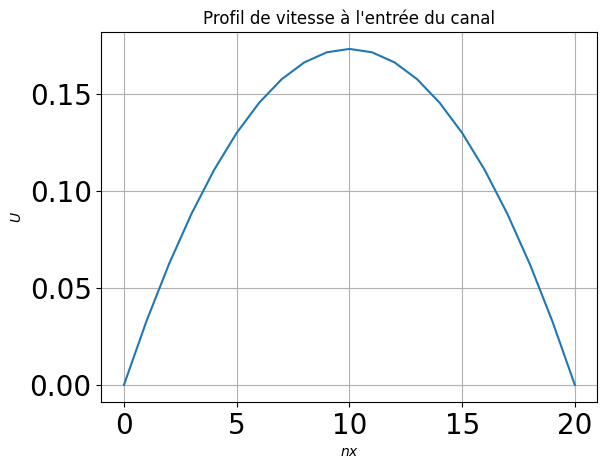

In [18]:
plt.plot(inlet_profile())
plt.title("Profil de vitesse à l'entrée du canal")
plt.xlabel('$nx$')
plt.ylabel('$U$')
plt.grid()

# Première analyse de l'écoulement

<b style="color:#0055FA">1. En reprenant les éléments développés dans les TP précédents, réaliser une simulation de cet écoulement pour un nombre de Reynolds de 100 et une résolution initiale de 20 points. On représentera le champ de vitesse longitudinale ainsi que les lignes de courant pour donner une première analyse de l'écoulement.</b>

In [13]:
def plot_mesh(ux, uy, Re=None):
    lx, ly = ux.shape[0], ux.shape[1]

    x = np.linspace(0, lx-1, lx)/L
    y = np.linspace(0, ly-1, ly)/H
    plt.streamplot(x, y, ux.T, uy.T, color='w',density=2., linewidth=0.4)
    plt.pcolormesh(x, y, ux.T/U0)
    cbar = plt.colorbar()
    cbar.set_label('$u_x/U_0$', rotation=270, labelpad=10, fontsize=fs)
    plt.xlabel('$X/L$',fontsize=fs);plt.ylabel('$Y/H$',fontsize=fs)
    plt.axis('equal')
    if Re is not None:
        plt.title(f"Simulation d'écoulement pour $Re={Re}$",fontsize=fs)

-------------------------------------------------------------------------------------------
PROCESSING NEW SIMULATION

🌊 Re = 100
🔲 Grid resolution: nx = 315, ny = 42, nt = 3000
📜 Saving results = False
⏱ 3000 iterations in 14.13235330581665s
⚡ Performance : 2.808  MLUPS
-------------------------------------------------------------------------------------------


C:\Users\theov\AppData\Local\Temp\ipykernel_20876\2325152924.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


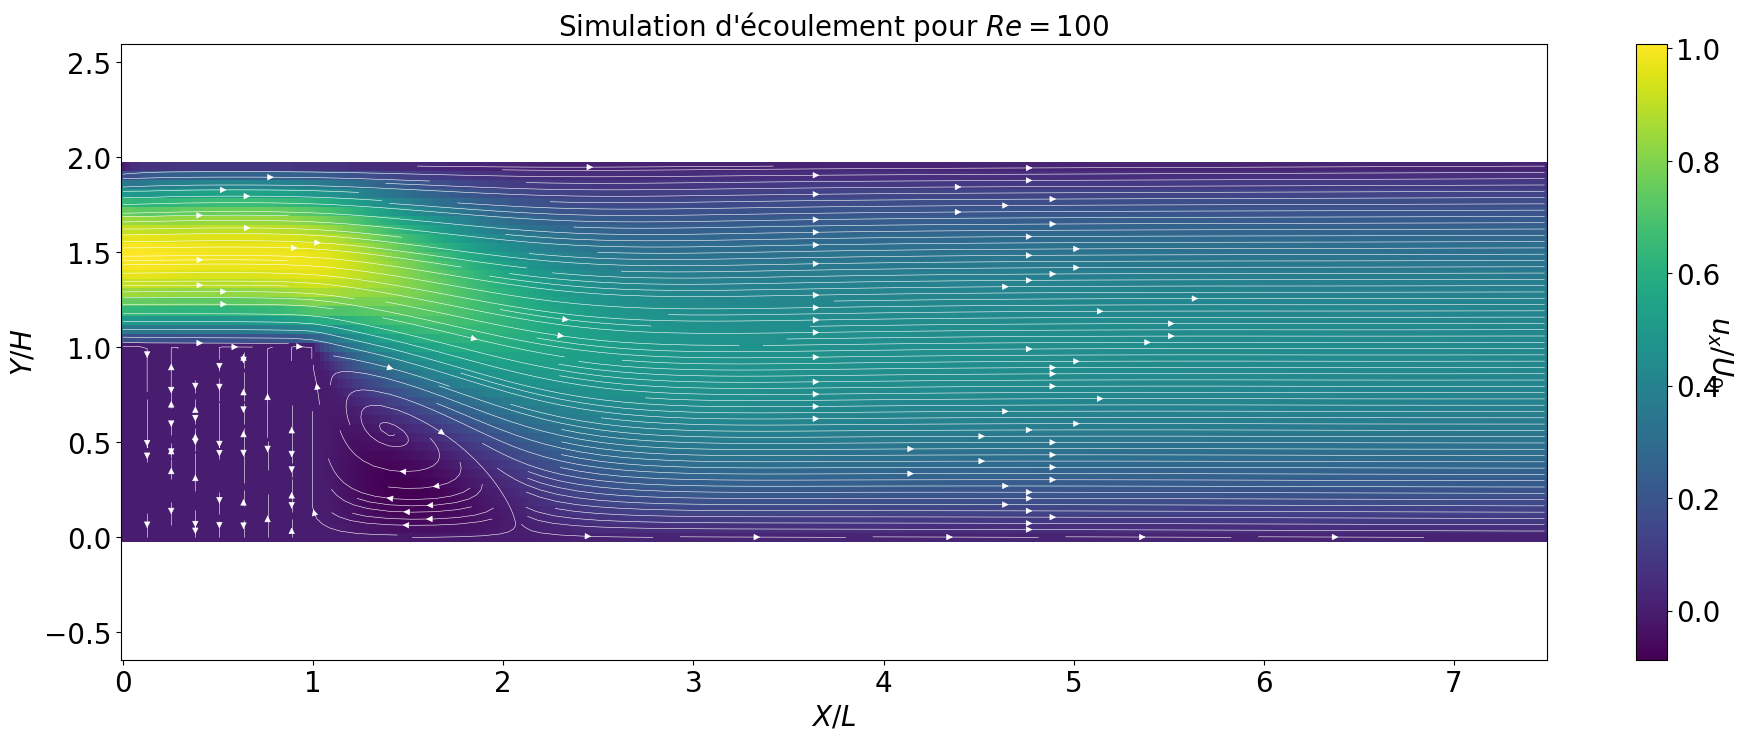

In [19]:
# Résolution initiale de 20 points, + un dernier pour le milieu du profil de vitesse parabolique
H = 21
L=2*H
nx = 15*H
ny = 2*H
Re=100
ux, uy, _, _, _ = simulate(Re=Re, nt=3000)

fig, ax = plt.subplots(figsize=(23,8))
plot_mesh(ux, uy, Re=Re)
fig.show()

A un nombre de Reynolds $Re = 100$ et une résolution de 20 points, on observe que le fluide rentre d'abord dans le domaine avec un profil de vitesse longitudinale. La longueur $L$ de la marche semble suffisante pour que ce régime stationnaire persiste jusqu'à la marche. Cependant, l'écoulement est perturbé par cette dernière marche descendante : un tourbillon apparait devant cette marche, et s'étend sur une longueur équivalente à celle de la marche. Cela est communément appelé une **bulle de recirculation**, et est un phénomène bien documenté notamment dans les références qui seront citées par la suite ([1], [2], [3], [4]). Enfin, loin de celle-ci $X/L \approx 3$, le profil de vitesse redevient parabolique.

Ce premier résultat est conforme à l'expérience ainsi qu'aux simulations numériques usuellement pratiquées, par exemple celles réalisées par Biswas _et al_ et présentés dans leur Figure 3 [4]. En effet, un nombre de Reynolds $Re = 100$ peut déjà être considéré important pour que le terme inertiel entre en jeu et crée ces tourbillons, signe d'une vorticité à cette zone. Notamment, le nombre employé ici correspond à un $Re_D = 66.6$ dans la notation de Biswas _et al_ (voir partie sur la longueur de recirculation pour le calcul exact), et l'écoulement observé dans la présente étude correspond qualitativement à celui obtenu figure 3.e [4] : la bulle se développe sur presque toute la hauteur de la marche (un très faible espace subsistant) et s'étend en longueur.

La création de la bulle de recirculation peut être vue comme le développement d'une instabilité à l'écoulement de base, qui serait parabolique sur toute la longueur du canal. En effet, lors du franchissement du coin de la marche, l'écoulement devient parallèle cisaillé, ce qui est instable dès que la différence de vitesses entre les deux zones - ici la tranche correspondant au canal d'entrée, et celle devant la marche descendante - est différente.

Par ailleurs, d'après les simulations et les prédictions de Moffatt _et al_ cité dans [4], dans un écoulement réel, une infinité de tourbillons devrait être présente dans le coin inférieur de la marche descendante, de taille décroissante et toujours plus proches de ce coin. Numériquement, il est cependant impossible d'observer une telle cascade infinie de tourbillons, dû à la résolution minimale de l'écoulement qui correspond à une maille. Dans ce premier exemple, nous n'observons qu'un seul tourbillon, mais augmenter la résolution du domaine fera apparaitre de nouveaux tourbillons dans le coin, un sujet abordé dans la prochaine section.

# Convergence

<b style="color:#0055FA">2. Pour vérifier la convergence du maillage, on peut par exemple regarder la longueur de la bulle de recirculation $L_r$ se formant en aval du décollement. Déterminer alors à partir de quelle résolution (combien de point dans la hauteur de la marche) la convergence est atteinte.</b>

## Utilitaire : calcul des positions de recirculation

Nous utilisons la définition simple formulée par Mansour _et al_ : une bulle de recirculation correspond à une vitesse longitudinale $u_x$ opposée au reste de l'écoulement (ici, négative) le long d'une paroi, donc ses délimitations correspondent à un changement de signe de $u_x$ [2]. Comme les conditions limites utilisées correspondent à un fluide réel, la vitesse sur la paroi sera nulle, on se place alors sur la maille adjacente.

In [33]:
def get_recirculation_positions(ux: np.array) -> (np.array, np.array):
    '''
    Positions of the recirculation bubbles, relative to the step position, normalized using H
    :param ux: longitudinal speed
    :return: sign_change_bottom, sign_change_top
    '''
    sign_change_bottom = np.argwhere(np.diff(np.sign(ux[L:, 1])) != 0)
    # Filter out extremely local eddies on the bottom corner of the step
    # (See the section "Convergence" to find out more details about these local corner eddies)
    sign_change_bottom = sign_change_bottom[sign_change_bottom > L/5]
    sign_change_top = np.argwhere(np.diff(np.sign(ux[L:, -2])) != 0)

    return sign_change_bottom / H, sign_change_top / H

## Simulations pour différentes valeurs de H

In [38]:
H_range = [5, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111]

In [ ]:
Lr_H = np.zeros(len(H_range))

for i, H in enumerate(H_range):
    # Maillage/Domaine
    L=2*H         # Longueur incidente
    x0,y0=L,H     # Coordonnées du bord de la marche
    nx=7*H
    ny=2*H
    dx = 1./H
    dt=dx*c0 / c0_real
    Re=100
    _, _, _, Lr_t, _ = simulate(Re=Re, nt=4000, save_results=True, results_prefix='convergence_study')
    Lr_H[i] = Lr_t[-1]

np.save('./out/Lr_H.npy', Lr_H)

## Résultats et conclusion

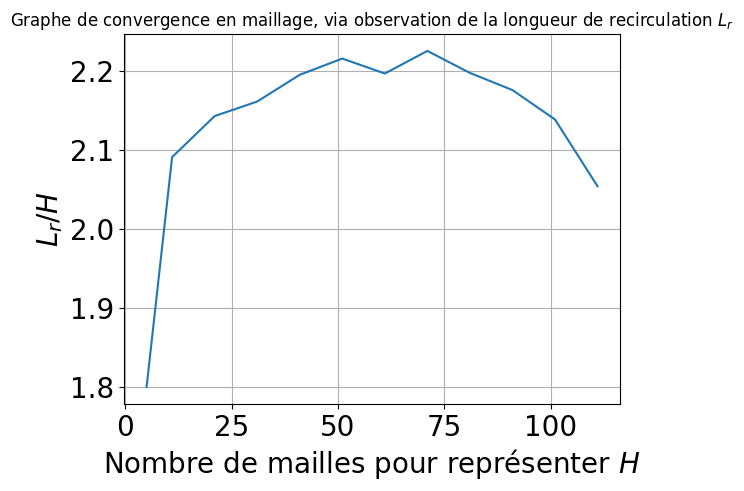

In [30]:
Lr_H = np.load('./out/Lr_H.npy')

plt.plot(H_range, (Lr_H - 1) * 2)
plt.xlabel('Nombre de mailles pour représenter $H$', fontsize=fs); plt.ylabel('$L_r/H$', fontsize=fs)
plt.title('Graphe de convergence en maillage, via observation de la longueur de recirculation $L_r$')
plt.grid()
plt.show()

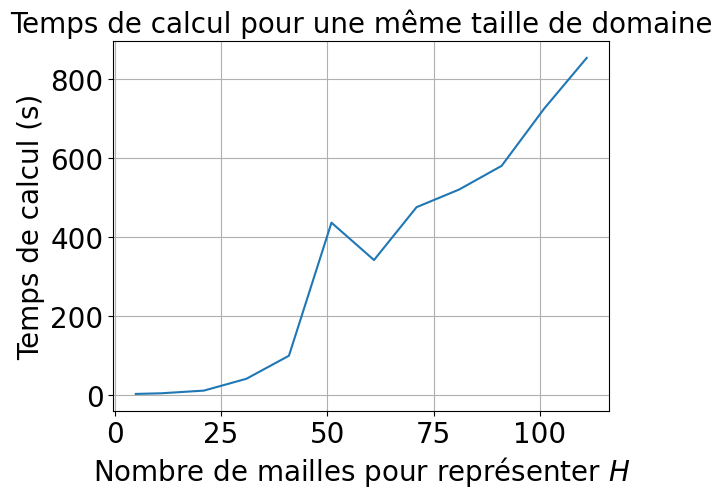

In [20]:
# Temps de calcul mesurés pour chaque valeur de H
times = [2.208141326904297, 3.827563762664795, 10.60402536392212, 40.57016205787659, 98.96918511390686, 436.1536982059479, 341.4263153076172, 475.3926520347595, 520.0598404407501, 580.1280829906464, 725.1534354686737, 853.6033363342285]

plt.plot(H_range, times)
plt.xlabel('Nombre de mailles pour représenter $H$', fontsize=fs); plt.ylabel('Temps de calcul (s)', fontsize=fs)
plt.title('Temps de calcul pour une même taille de domaine', fontsize=fs)
plt.grid()
plt.show()

In [ ]:
(Lr_H[5] - Lr_H[4]) / Lr_H[4]

In [ ]:
(times[5] - times[4]) / times[4]

Passé $H = 41$, la précision de la longueur de recirculation n'augmente que de 0.7%, tandis que le temps de calcul explose (+ 300%). Nous considérerons par la suite $H = 41$ comme une valeur optimale, résultant en des simulations presque convergées, pour des temps de calcul raisonnables. De nombreuses expérimentations doivent en effet être conduites en faisant varier les paramètres sur des larges intervalles (plus d'une dizaine à tester), il serait alors bien trop long et fastitieux d'augmenter la résolution dans le cadre de ce projet. Nous nous concentrerons alors sur l'interprétation des résultats et la confrontation avec la bibliographie, en gardant en tête cet enjeu de convergence en maillage.

Une explication de la diminution de $L_r$ pour des valeurs $H > 41$ est apportée par l'analyse suivante, en s'intéressant au coin inférieur de la marche.

### Zoom dans le coin de la marche

C:\Users\theov\AppData\Local\Temp\ipykernel_20876\4051446871.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


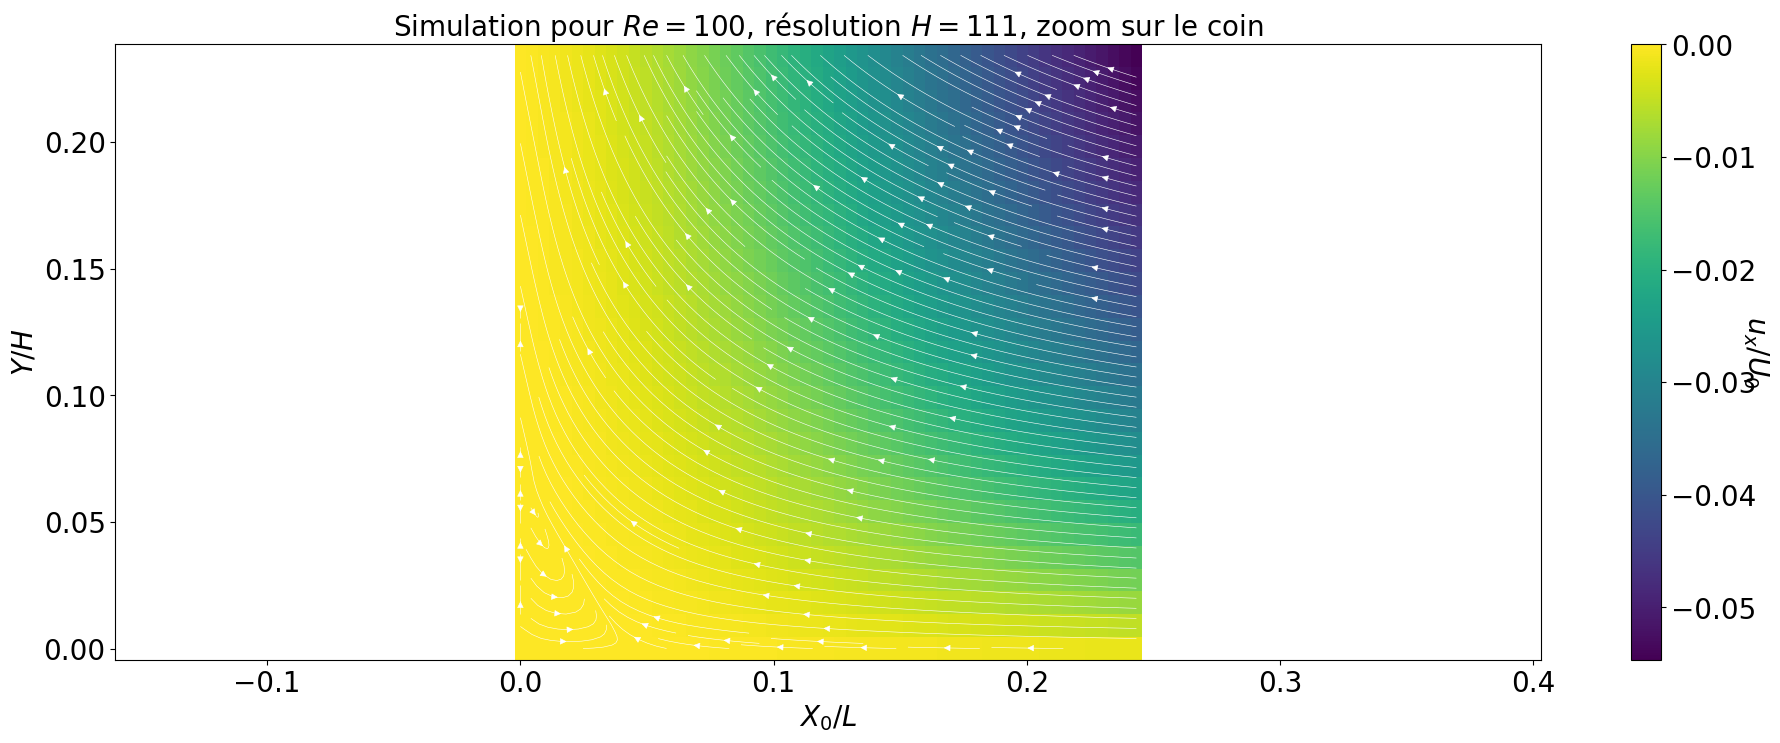

In [22]:
# Résolution initiale de 20 points, + un dernier pour le milieu du profil de vitesse parabolique
ux, uy = np.load('./out/convergence_study-ux-100.npy'), np.load('./out/convergence_study-uy-100.npy')
Re = 100

H=111
L=2*H         # Longueur incidente
x0,y0=L,H     # Coordonnées du bord de la marche

x_min, x_max = x0, int(5*x0/4)
y_min, y_max = 0, int(y0/4)

fig, ax = plt.subplots(figsize=(23,8))
plot_mesh(ux[x_min:x_max, y_min:y_max], uy[x_min:x_max, y_min:y_max], Re=Re)
plt.title(f'Simulation pour $Re={Re}$, résolution $H=111$, zoom sur le coin', fontsize=fs)
plt.xlabel('$X_0/L$', fontsize=fs)
fig.show()

Pour une résolution suffisemment grande, nous voyons effectivement apparaitre un tourbillon secondaire, comme décrit par Moffatt _et al_ cité dans [4]. Sa présence peut être à l'origine du décallage de la longueur de recirculation présente, car il influence la bulle de recirculation et donc potentiellement l'écoulement en aval de celle-ci.

# Coefficient de pression

<b style="color:#0055FA">3. Tracer le coefficient de pression $C_p=\frac{p-p_0}{\frac{1}{2}\rho_0 U_0^2}$ en fonction de $X$. Commenter le résultat et relier l'évolution de ce coefficient à celui de la vitesse longitudinale.</b>

Ici, le coefficient de pression $C_p$ ainsi que la vitesse longitudinale $u_x$ sont tracés sur le bord inférieur, qui est celui contenant la principale bulle de recirculation (collée au dos de la marche descendante). Pour faciliter la comparaison avec la biliographie, ces grandeurs sont tracées en fonction de la distance $X_0$ à la marche, normalisée par la hauteur $H$ de cette même marche.

In [40]:
ux.shape

(492, 82)

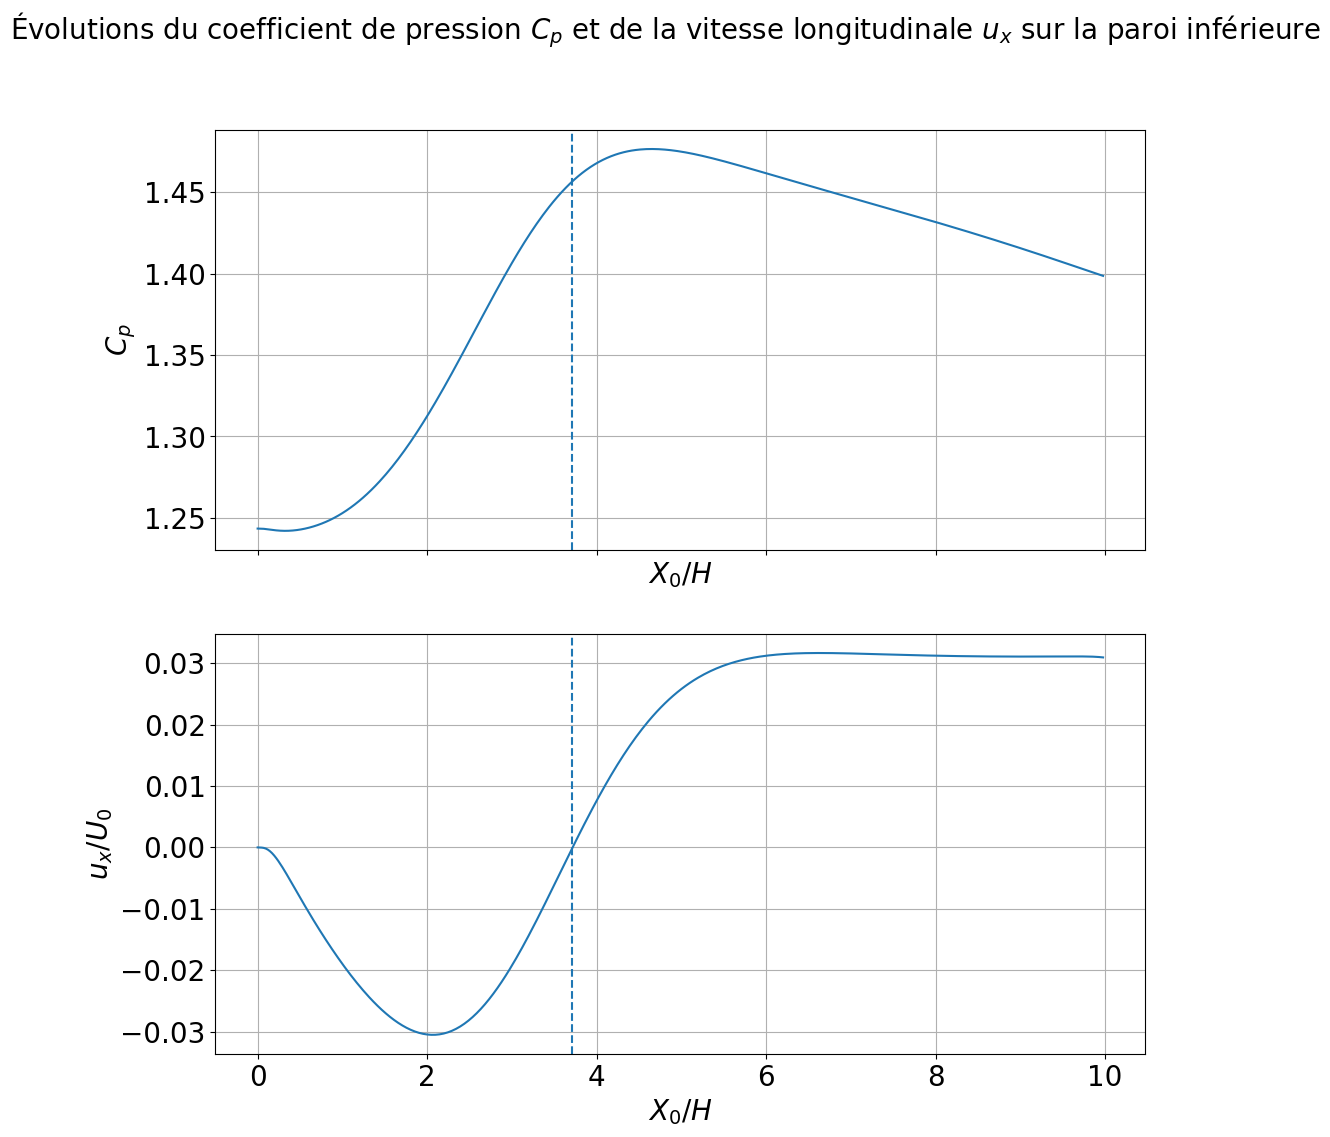

In [48]:
Re = 200
H=41
L=2*H
x0,y0=L,H
ux = np.load(f'./out/ux-{Re}.npy')
rho = np.load(f'./out/rho-{Re}.npy')

rho0 = 1
Cp = (rho - rho0) / (1/2 * rho0 * M0**2)
n_p = len(Cp)
x = np.linspace(0, n_p-x0-1, n_p-x0)/H

sign_change_bottom, _ = get_recirculation_positions(ux)

fig, (Cp_ax, ux_ax) = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex=True)
fig.suptitle('Évolutions du coefficient de pression $C_p$ et de la vitesse longitudinale $u_x$ sur la paroi inférieure', fontsize=fs)

plt.sca(Cp_ax)
plt.grid()
plt.plot(x, Cp[x0:, 1])
plt.axvline(sign_change_bottom[0], linestyle='dashed')
plt.xlabel('$X_0/H$',fontsize=fs);plt.ylabel('$C_p$',fontsize=fs)

plt.sca(ux_ax)
plt.grid()
plt.axvline(sign_change_bottom[0], linestyle='dashed')
plt.plot(x, ux[x0:, 1] / U0)

plt.xlabel('$X_0/H$',fontsize=fs); plt.ylabel('$u_x/U_0$',fontsize=fs)
plt.show()

In [42]:
ux[L, :H]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

_Pour mieux interpréter l'évolution du coefficient de pression $C_p$, les traits en pointillés représentent les positions de changement de signe de la vitesse longitudinale $u_x$ le long de la paroi._

Pour cette simulation, la zone de recirculation - caractérisée par une vitesse longitudinale $u_x$ négative - est présente sur une longueur de $4H$ derrière la marche. Sur ce même intervalle, le coefficient de pression est bien inférieur à sa valeur dans la zone stabilisée du canal. La bulle de recirculation crée donc une **dépression** dans l'écoulement. On peut supposer que le gradient de pression défavorable le long de ce bord inférieur est à l'origine du décollement en haut de la marche, dont le recollement ne se situe qu'en aval de cette bulle.

L'évolution linéaire du coefficient de pression, à partir $X_0 \approx 5H$, correspond bien à la théorie de l'écoulement de Poiseuille dans un canal 2D. En effet, dans cette situation, le gradient de pression est constant et négatif, car l'écoulement se dirige vers les $x$ positifs. Sa valeur analytique dimensionnelle est $\frac{\partial p}{\partial x} = -8 \mu U_{in,m} < 0$.

_Point de détail qui a ici son importance : la vitesse longitudinale $u_x$ est bien nulle pour $X_0 = 0$, donc contre la marche descendante. Les conditions limites sont ici respectées._

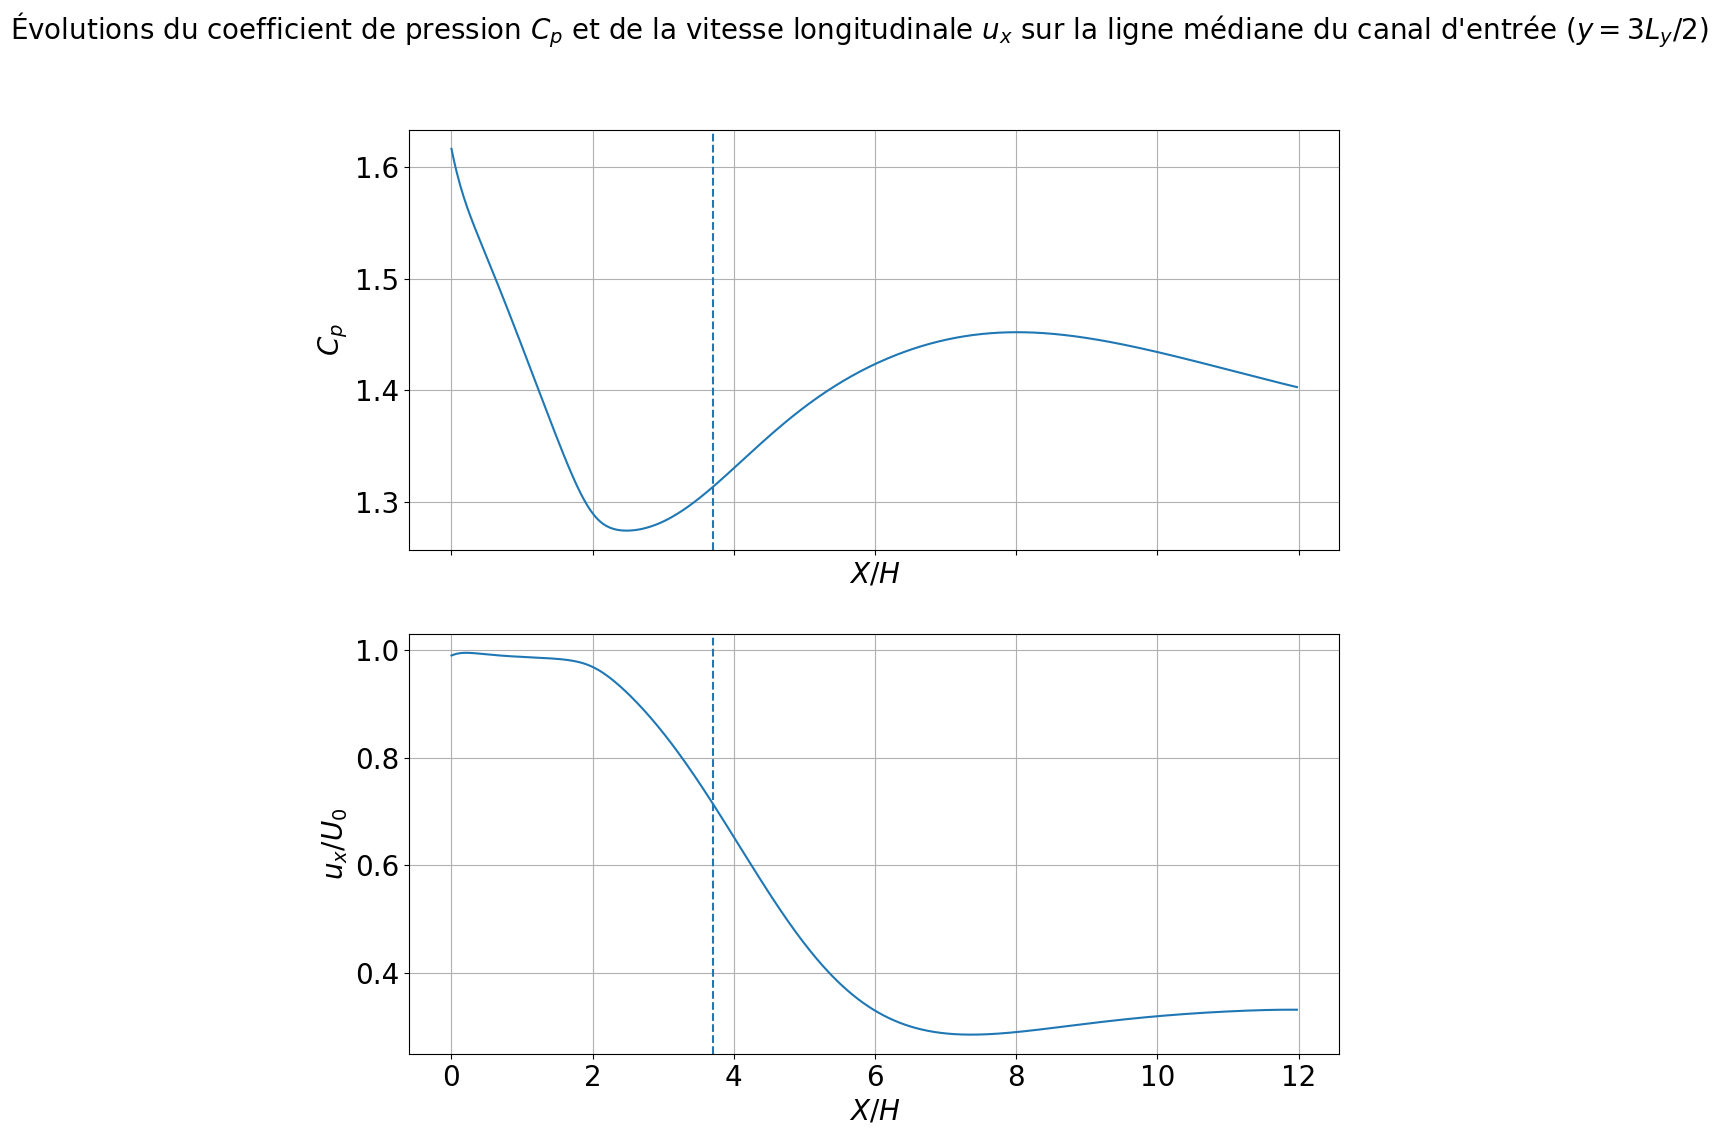

In [58]:
Re = 200
H=41
L=2*H
x0,y0=L,H
ux = np.load(f'./out/ux-{Re}.npy')
rho = np.load(f'./out/rho-{Re}.npy')

rho0 = 1
Cp = (rho - rho0) / (1/2 * rho0 * M0**2)
n_p = len(Cp)
x = np.linspace(0, n_p-1, n_p)/H

sign_change_bottom, _ = get_recirculation_positions(ux)

fig, (Cp_ax, ux_ax) = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex=True)
fig.suptitle("Évolutions du coefficient de pression $C_p$ et de la vitesse longitudinale $u_x$ sur la ligne médiane du canal d'entrée ($y = 3L_y/2$)", fontsize=fs)

plt.sca(Cp_ax)
plt.grid()
plt.plot(x, Cp[:, int(3*ny/2)])
plt.axvline(sign_change_bottom[0], linestyle='dashed')
plt.xlabel('$X/H$',fontsize=fs);plt.ylabel('$C_p$',fontsize=fs)

plt.sca(ux_ax)
plt.grid()
plt.axvline(sign_change_bottom[0], linestyle='dashed')
plt.plot(x, ux[:, int(3*ny/2)] / U0)

plt.xlabel('$X/H$',fontsize=fs); plt.ylabel('$u_x/U_0$',fontsize=fs)
plt.show()

Lorsque l'on regarde le coefficient de pression au milieu du canal d'entrée, la décroissance initiale est bien linéaire, correspondant à un écoulement de Poiseuille établi en entrée. Il en est de même pour le canal de sortie suffisemment loin de la bulle de recirculation, avec une pente moins forte.

La vitesse longitudinale décroit après avoir passé la marche descendante - qui constitue une augmentation brutale de la taille du domaine - car la section de sortie est plus importante pour un même débit. D'après Biswas _et al_ qui a étudié ce phénomène dans le contexte de la marche descendante, cela engendre donc une augmentation de la pression dû à l'effet Bernoulli [4]. Les résultats de la présente étude sont par ailleurs cohérents avec les graphiques de différence de pression obtenus par Biswas _et al_ et reporté dans leur Figure 10.

On observe par ailleurs que la vitesse longitudinale $u_x$ sur la ligne médiane n'est pas constante dans le canal d'entrée, mais décroit très légèrement. L'écoulement amont est donc influencé par l'écoulement aval, une propriété singulière du problème de la marche descendante déjà décrite par Amashy _et al_ [1].

# Topologie de l'écoulement

> Par la suite, afin de réaliser une comparaison directe avec la bibliographie, certaines grandeurs seront représentées en fonction de la distance $X_0$ la à la marche descendante ($X_0 = X - L$), cette même valeur étant adimensionnée par H.

<b style="color:#0055FA">4. Etudier l'influence du nombre de Reynolds sur la topologie de l'écoulement. On pourra par exemple tracer $L_r(Re)$ et $C_p(X,Re)$. </b>

D'après les résultats expérimentaux, notamment de Armaly et al. [1], ainsi que les simulations numériques [2], lorsque le nombre de Reynolds augmente, des bulles de recirculation additionnelles apparaissent dans le canal, et sont de plus en plus éloignées de la marche descendante. La longueur du canal a donc été agrandie à chaque incrément du nombre de Reynolds $Re$ pour tenir compte de cette possibilité.

In [60]:
H = 41

Re_range = [20,  50,   100,  200,  400,  600,  800,  1000, 1200, 1400, 1600]
nt_range = [501, 1001, 2001, 4001, 6001, 7001, 9001, 10001, 11001, 12001, 13001]
nx_range = [5*H, 6*H, 8*H, 12*H, 16*H, 20*H, 24*H, 23*H, 24*H, 25*H, 26*H]

L=2*H
x0,y0=L,H
nx = 6*H
ny=2*H
dx = 1./H
dt=dx*c0 / c0_real

### Simulations pour différentes valeurs de $Re$

In [ ]:
for i, Re in enumerate(Re_range):
    nx = nx_range[i]
    ux = np.load(f'./out/continued-ux-{Re}.npy')
    uy = np.load(f'./out/continued-uy-{Re}.npy')
    rho = np.load(f'./out/continued-rho-{Re}.npy')
    simulate(Re=Re, nt=nt_range[i], save_results=True, results_prefix='continued-bis', initial_conditions=(ux, uy, rho))

## Regroupement des positions de recirculation

In [55]:
import pandas as pd

data_df = pd.DataFrame(columns=['Re', 'x1_b', 'x2_b', 'x3_b', 'x4_b', 'x1_t', 'x2_t', 'x3_t', 'x4_t', 'max_p'])

mapping = {
    'bottom': [1, 2, 3],
    'top': [4, 5]
}

for Re in Re_range:
    ux = np.load(f'./out/ux-{Re}.npy')
    uy = np.load(f'./out/uy-{Re}.npy')
    rho = np.load(f'./out/rho-{Re}.npy')
    # Lr_t = np.load(f'./out/Lr_t-{Re}.npy')
    # max_p_t = np.load(f'./out/max_p_t-{Re}.npy')
    sign_change_bottom, sign_change_top = get_recirculation_positions(ux)

    for i, pos in enumerate(sign_change_bottom):
        if i < 4:
            data_df.loc[len(data_df)] = {
                'Re': Re,
                f'x{i+1}_b': pos
            }

    for i, pos in enumerate(sign_change_top):
        if i < 4:
            data_df.loc[len(data_df)] = {
                'Re': Re,
                f'x{i+1}_t': pos
            }


## Résultats

### Allure qualitative de l'écoulement

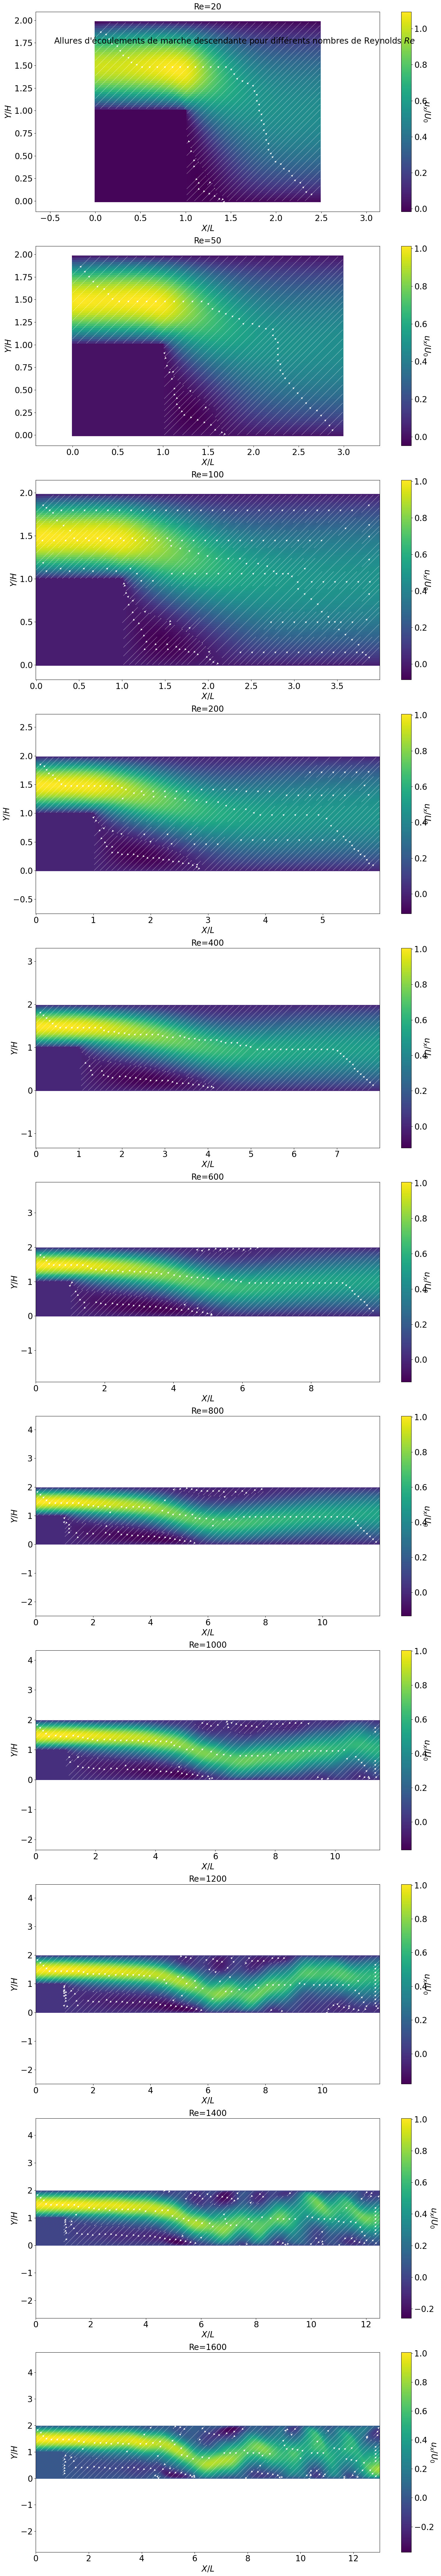

In [56]:
nb_Re = len(Re_range)

fig, ax = plt.subplots(nb_Re, ncols=1, figsize=(16, 8*nb_Re))
fig.suptitle("Allures d'écoulements de marche descendante pour différents nombres de Reynolds $Re$", fontsize=fs)

for i, Re in enumerate(Re_range):
    plt.sca(ax[i])
    ux = np.load(f'./out/ux-{Re}.npy')
    uy = np.load(f'./out/ux-{Re}.npy')
    plot_mesh(ux, uy, Re=Re)

fig.tight_layout()
plt.show()

A très bas Reynolds $Re = 20$, la bulle de recirculation est de taille réduite, et n'est pas développée sur toute la hauteur de la marche, mais plutôt sur les trois quarts. Cela est conforme à la figure 3.d de Biswas _et al_ pour un $Re_D = 13.33$ donc proche de 10.

Une augmentation du nombre de Reynolds $Re$ engendre ensuite une augmentation de la longueur de recirculation. L'écoulement est en effet moins visqueux et possède donc davantage d'inertie, il ne pourra donc pas se recoller aussi rapidement en provenant de manière laminaire du canal d'entrée.

Conformément aux descriptions expérimentales, lorsque le nombre de Reynolds $Re$ augmente, des bulles de recirculation additionnelles apparaissent en aval de la marche descendante :

- Pour $Re \geq 600$, une bulle apparait sur la paroi supérieure
- Pour $Re \geq 1000$, une bulle secondaire apparait, et même bulle terciaire (qui se remarque davantage à $Re = 1200$)
- Pour $Re \geq 1400$, la bulle de la paroi supérieure se brise en plusieurs bulles, l'écoulement se complexifie grandement

Pour $Re > 1200$, d'après Armaly _et al_, la transition à la turbulence s'établit [1] : il faudrait alors prendre en compte la turbulence dans le modèle numérique employé, ce que notre modèle BGK basique ne fait pas. Un temps de relaxation lié à la viscosité doit en effet être ajouté au temps de relaxation utilisé au sein de l'opérateur de collision. Cette limitation s'observe pour $Re = 1600$, le courant devenant très perturbé loin de la marche et ne se stabilisant visiblement pas, or il est admis que la viscosité joue un rôle stabilisant par dissipation de l'énergie aux petites échelles (cascade de Kolmogorov). Notre modèle prédit tout de même l'apparition d'une bulle de recirculation secondaire sur la paroi inférieure.

D'après Armaly _et al_, la première bulle sur la paroi supérieure est dûe à un gradient de pression adverse généré par la présence de le bord de la marche descendante [1]. Cela peut se vérifier numériquement au travers de la figure ci-dessous : lorsque $Re$ augmente, l'écoulement connait une dépression de plus en plus importante sur la paroi supérieure, ce qui pourrait expliquer l'apparition de la bulle de recirculation.

L'écoulement donne alors l'impression de "slalomer" entre ses bulles de recirculation. En effet, chacune d'entre elle est provoquée par un gradient de pression adverse, ce qui dévie l'écoulement. Or, si celui-ci va trop vite, le gradient de pression sur le mur opposé restera adverse, créant une nouvelle bulle qui dévie l'écoulement, et ainsi de suite tant que ce gradient n'est plus adverse. L'effet est d'autant plus important que le nombre de Reynolds est grand, cf figure 7 de Chiang et al [3], et figure 9 présentant le résultat pour $Re = 2500$.

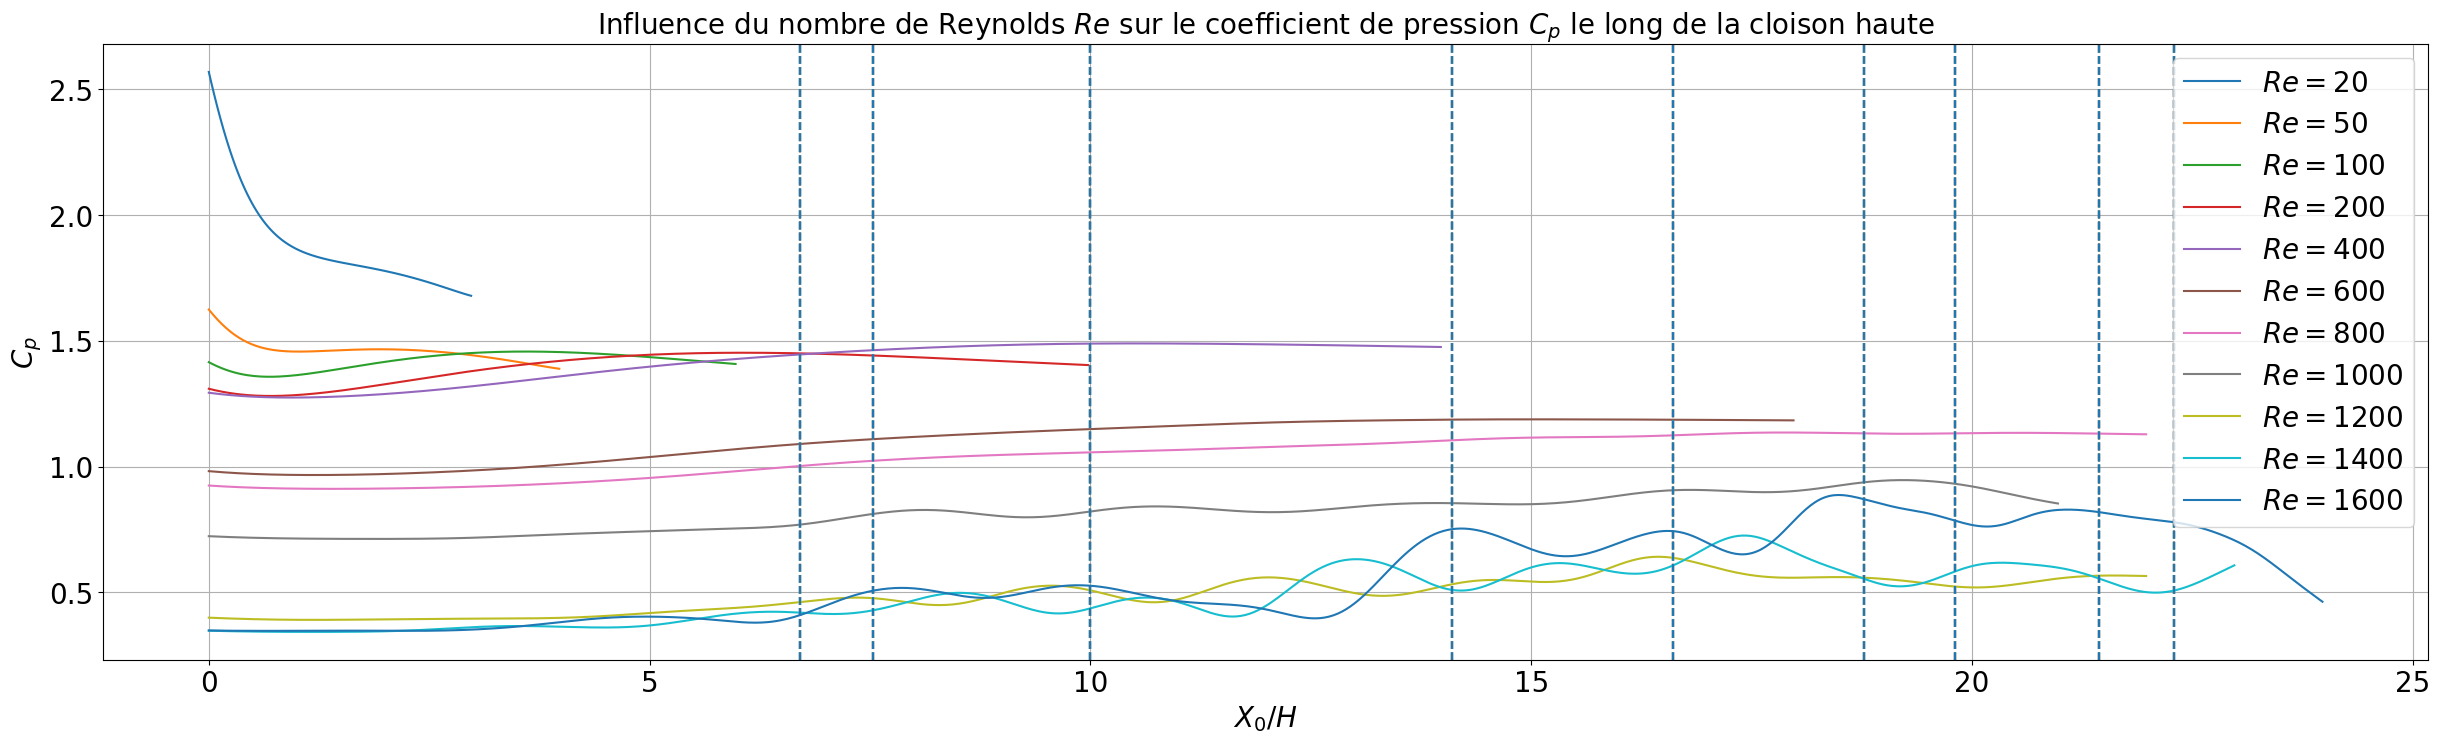

In [57]:
plt.subplots(figsize=(30, 8))

for i, Re in enumerate(Re_range):
    ux = np.load(f'./out/ux-{Re}.npy')
    rho = np.load(f'./out/rho-{Re}.npy')
    rho0 = 1
    Cp = (rho - rho0) / (1/2 * rho0 * M0**2)
    n = len(Cp)
    x = np.linspace(0, n - x0 - 1, n - x0)/H

    _, sign_change_top = get_recirculation_positions(ux)
    u_lid = ux[L:, 1]

    for pos in sign_change_bottom:
        plt.axvline(pos, color=colors[i % len(colors)], linestyle='dashed')

    plt.plot(x, Cp[L:, -1], label=f'$Re={Re}$')
    plt.ylabel('$C_p$',fontsize=fs)

plt.title('Influence du nombre de Reynolds $Re$ sur le coefficient de pression $C_p$ le long de la paroi supérieure', fontsize=fs)
plt.xlabel('$X_0/H$', fontsize=fs)
plt.legend(fontsize=fs)
plt.grid()
plt.show()

_Pour mieux interpréter l'évolution du coefficient de pression $C_p$, les traits en pointillés représentent les positions de changement de signe de la vitesse longitudinale $u_x$ le long de la paroi._

### Longueurs de recirculation $L_r (Re)$

Le nombre de Reynolds employé dans la présente étude est basé sur la hauteur totale du domaine $Re = \frac{U_0 L_y}{\nu} = 2 \frac{U_0 h}{\nu}$, tandis que celui employé par Armaly _et al_ utilise le diamètre hydraulique ainsi que les deux-tiers du maximum de vitesse du profil d'entrée : $Re_D = \frac{4}{3} \frac{U_0 h}{\nu}$ [1]. On applique donc la transformation suivante pour les nombres de Reynolds $Re$ utilisé dans la présente étude :

$$
Re_D = \frac{4}{3} \frac{Re}{2} = \frac{2}{3}Re
$$

Nous calculons alors bien les mêmes nombres que Armaly _et al_, correspondant à la même physique de l'écoulement.

In [58]:
# Data extracted using https://automeris.io/wpd/?v=5_2

armaly = pd.read_csv('armaly.csv', sep=',')

def get_partial_df(n):
    df = armaly[[f'Re_{n}', f'x{n}']].rename(columns={f'x{n}': 'x', f'Re_{n}': 'Re'}).sort_values(by='Re')
    return df[df.notnull()]

armaly_positions = {}

for i in range(1, 6):
    armaly_positions[f'x_{i}'] = get_partial_df(i)

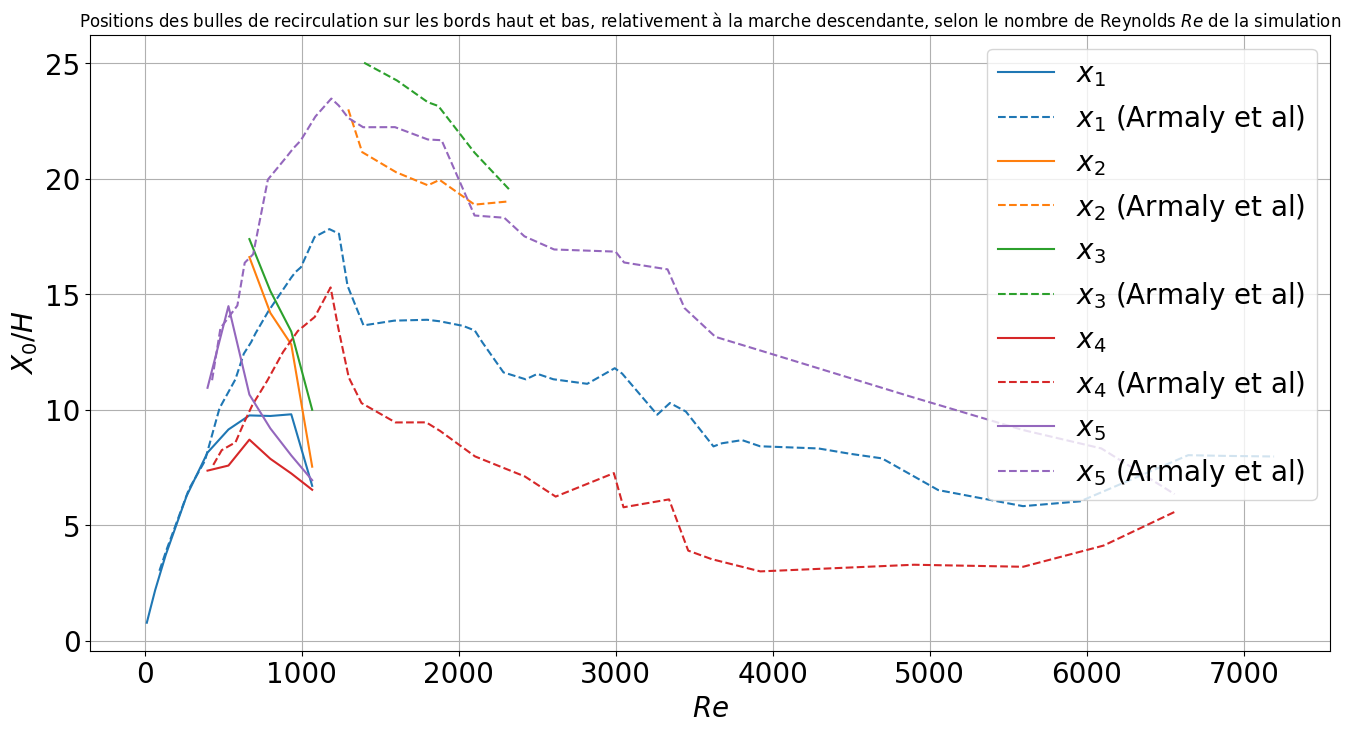

In [59]:
positions = ['x1_b', 'x2_b', 'x3_b', 'x4_b', 'x1_t', 'x2_t', 'x3_t', 'x4_t']
position_mapping = {
    'x1_b': 'x_1',
    'x2_b': 'x_2',
    'x3_b': 'x_3',
    'x1_t': 'x_4',
    'x2_t': 'x_5',
}

plt.figure(figsize=(16, 8))
plt.grid()

bibliography_comparison = True

for (simulation_name, armaly_name) in position_mapping.items():
    simulation_df = data_df[data_df[simulation_name].notnull()]
    p = plt.plot(simulation_df['Re']*2/3, simulation_df[simulation_name], label=f'${armaly_name}$')
    if bibliography_comparison:
        armaly_df = armaly_positions[armaly_name]
        plt.plot(armaly_df['Re'], armaly_df['x'], color=p[0].get_color(), linestyle='dashed', label=f'${armaly_name}$ (Armaly et al)')

plt.title('Positions des bulles de recirculation sur les bords haut et bas, relativement à la marche descendante, selon le nombre de Reynolds $Re$ de la simulation')
plt.xlabel('$Re$', fontsize=fs); plt.ylabel('$X_0/H$', fontsize=fs)
plt.legend(fontsize=fs)
plt.show()

Un nombre de Reynolds croissant correspond à une diminution de la viscosité, puisque la hauteur de la marche ainsi que la vitesse d'entrée sont fixées. Les effets visqueux laissent alors progressivement la place aux effets inertiels, et donc aux tourbillons et plus tard à la turbulence (nécessité d'invoquer une cascade de tourbillons pour dissiper efficacement l'énergie). Ainsi, plusieurs régimes se caractérisent :
- La bulle de recirculation grossit jusqu'à atteindre une valeur critique d'environ $20H$, puis chute brutalement
- Peu avant cette chute, une bulle apparait cette fois-ci sur la paroi supérieure, ici autour de $Re = 600$
- Une bulle secondaire se forme sur la paroi inférieure à la suite de la bulle primaire collée à la marche.

Les valeurs seuil de Reynolds pour l'apparition de la bulle sur la paroi supérieure, ainsi que celui correspondant au maximum de la longueur de recirculation, sont proches des valeurs expérimentales de Armaly _et al_ [1]. La dynamique d'apparition des bulles est la même : apparition puis mitigation de celle du dessus, apparition dans cet intervalle d'une seconde sur la paroi inférieure.

La longueur de recirculation $x_1$ est cependant sous-estimée par notre modèle pour $Re > 400$, de même pour la bulle secondaire, ce qui peut s'expliquer par des effets numériques. En effet, les simulations réalisées par Armaly _et al_ utilisant un schéma de différences finies montrent également des sous-estimations de plus en plus fortes à cause des erreurs de troncature. Comme postulé par les chercheurs, cela est certainement lié au manque de prise en compte des effets tridimensionnels à partir de $Re = 400$, qui deviennent non négligeable comme montré par les simulations par volumes finis de Biswas _et al_ [4]. L'équipe de Mansour _et al_ ont tenté de corriger ces écarts en utilisant un modèle $k-\epsilon$ avec un terme additionnel de rotation [2], qui engendre cependant une surestimation de la longueur de recirculation à partir de $Re = 400$. Dans notre présente étude utilisant la méthode Lattice-Boltzmann, la conservation du troisième moment, non effectuée par le modèle `D2Q9`, pourrait réduire légèrement cet écart. Le nombre de Mach $M_0 = 0.3$ est en effet déjà important pour que les termes d'erreurs commencent à ne plus être négligeables.

De plus, la bulle de recirculation secondaire sur la paroi inférieure apparait trop tôt dans la présente étude par rapport aux expériences d'Armaly _et al_. Cela peut être dû à la non prise en compte des effets 3D, qui auraient cassé la dynamique de l'écoulement sur la paroi supérieure, empêchant cette bulle d'apparaitre (par exemple, par une meilleure répartition de la pression et donc un gradient qui ne serait pas encore adverse).

Enfin, la méthode de mesure des positions de recirculation employée par Armaly _et al_ est bien plus précise, se basant sur une définition de moyenne temporelle. Le calcul employé dans la présente est moins précis et cela peut engendrer des erreurs additionnelles.

### Coefficient de pression sur le bord inférieur $C_p (X, Re)$

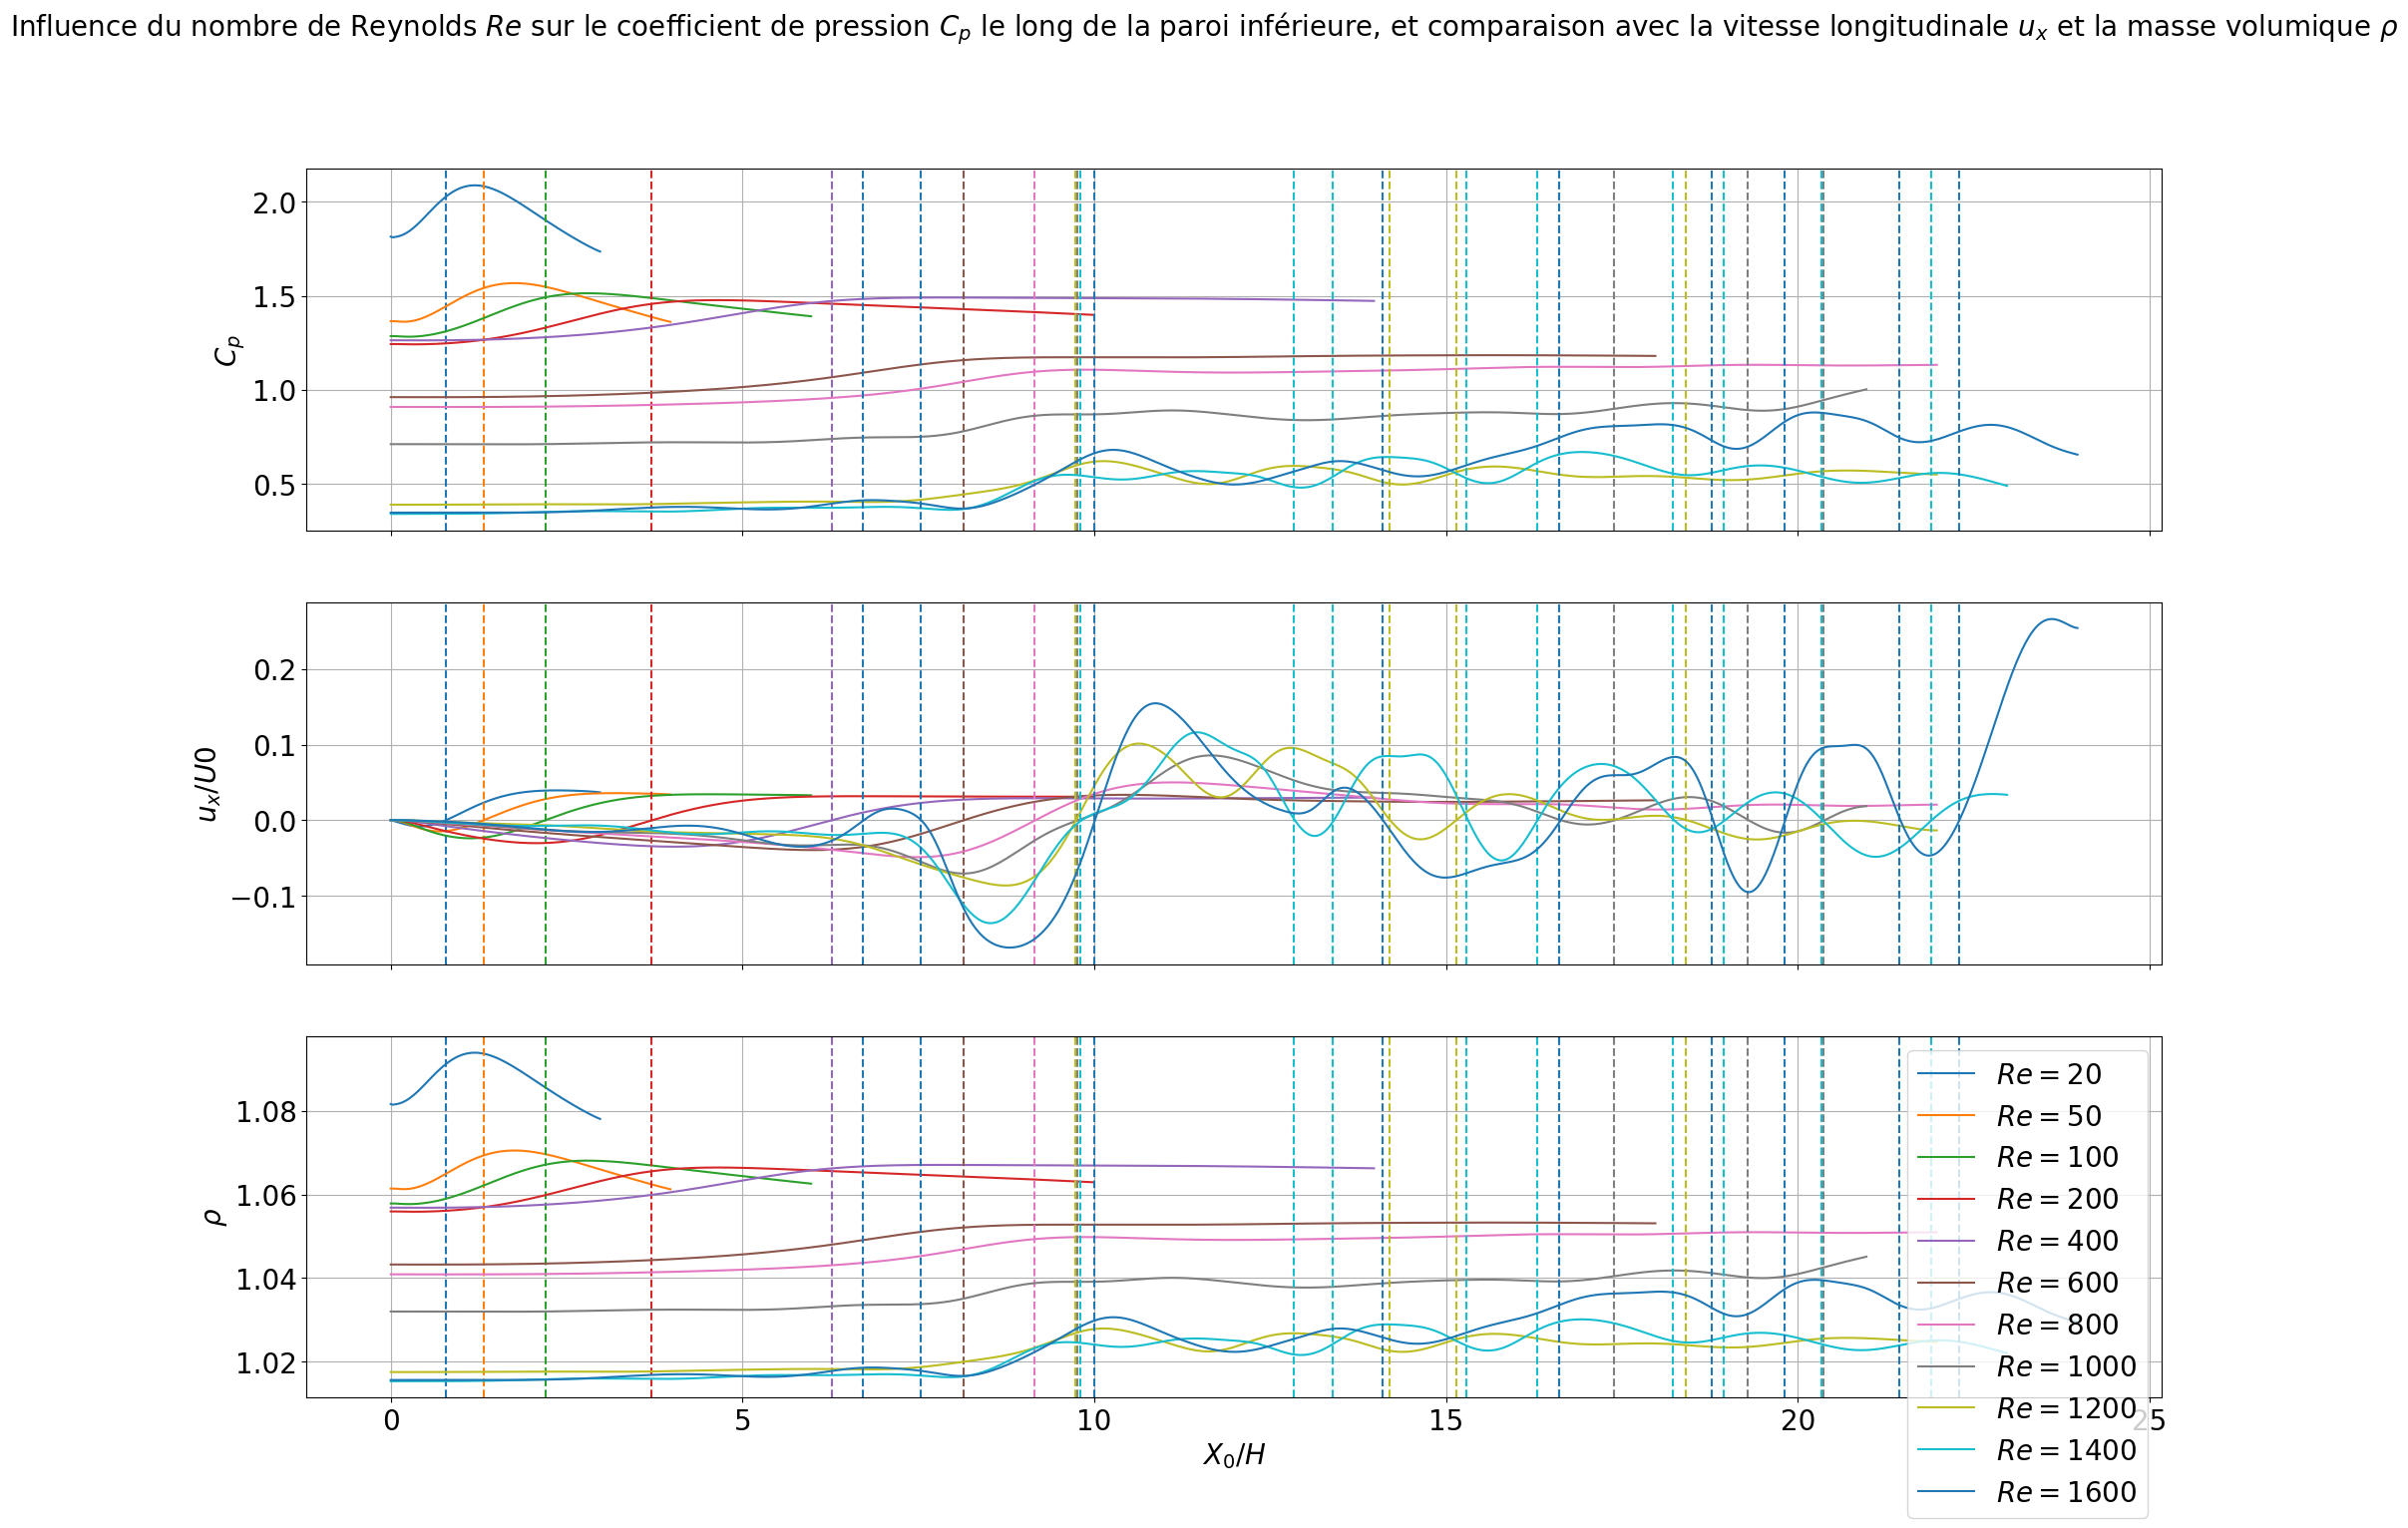

In [60]:
fig, (Cp_ax, ux_ax, rho_ax) = plt.subplots(figsize=(24, 16), nrows=3, ncols=1, sharex=True)
fig.suptitle('Influence du nombre de Reynolds $Re$ sur le coefficient de pression $C_p$ le long de la paroi inférieure, et comparaison avec la vitesse longitudinale $u_x$ et la masse volumique $\\rho$', fontsize=fs)

for i, Re in enumerate(Re_range):
    ux = np.load(f'./out/ux-{int(Re)}.npy')
    rho = np.load(f'./out/rho-{int(Re)}.npy')

    rho0 = 1
    Cp = (rho - rho0) / (1/2 * rho0 * M0**2)
    n_p = len(Cp)

    sign_change_bottom, sign_change_top = get_recirculation_positions(ux)

    x_lid = np.linspace(0, n_p - x0 - 1, n_p - x0) / H
    u_lid = ux[L:, 1]
    Cp_lid = Cp[L:, 0]
    rho_lid = rho[L:, 0]

    plt.sca(Cp_ax)
    plt.plot(x_lid, Cp_lid, label=f'$Re = {Re}$')
    for pos in sign_change_bottom:
        plt.axvline(pos, color=colors[i % len(colors)], linestyle='dashed')
    plt.ylabel('$C_p$',fontsize=fs)
    Cp_ax.grid()

    plt.sca(ux_ax)
    plt.plot(x_lid, u_lid / U0, label=f'$Re = {Re}$')
    plt.ylabel('$u_x/U0$',fontsize=fs)
    for pos in sign_change_bottom:
        plt.axvline(pos, color=colors[i % len(colors)], linestyle='dashed')
    ux_ax.grid()

    plt.sca(rho_ax)
    plt.plot(x_lid, rho_lid, label=f'$Re = {Re}$')
    for pos in sign_change_bottom:
        plt.axvline(pos, color=colors[i % len(colors)], linestyle='dashed')
    plt.ylabel('$\\rho$',fontsize=fs)
    rho_ax.grid()

plt.xlabel('$X_0/H$',fontsize=fs)
plt.legend(fontsize=fs)
plt.show()

_Sur ce graphique, les traits en pointillés correspondent à un changement de signe de la vitesse longitudinale, et sont un indicateur visuel afin de mieux comprendre la dynamique du coefficient de pression._

Comme étudié précédemment, une augmentation du nombre de Reynolds augmente progressivement le nombre de bulles de recirculation présentes dans l'écoulement. La conséquence immédiate est un plus grand nombre de zones de dépression, correspondant exactement à ces emplacements. Les amplitudes de dépression et de surpression deviennent d'ailleurs plus importantes avec $Re$.

L'augmentation du nombre de Reynolds a également pour effet une diminution globale de la valeur du coefficient de pression - du moins, au voisinnage de la marche et jusqu'à la sortie de la première zone de recirculation. Cela est directement causé par le choix du coefficient $C_p$ ainsi que l'utilisation de la référence des masses volumiques $\rho_0 = 1$, car comme montré sur le graphique de la masse volumique, celle-ci a tendance à diminuer lorsque le nombre de Reynolds $Re$ augmente.

Comme la longueur utilisée $2H$ ainsi que la vitesse $U_0 = M_0 \times c_0$ restent constantes, alors pour une augmentation du nombre de Reynolds $Re$, seule la viscosité $\nu$ peut diminuer. Comme $\rho$ diminue également avec $Re$, on en déduit que la viscosité dynamique $\mu$ a fortement diminué. Cela a pour effet de diminuer la pente de décroissance de la pression sur la section de sortie, conformément au comportement d'un écoulement de Poiseuille dans un canal bidimensionnel discuté précédemment.

### Position du maximum de pression sur le bord inférieur $max_p (t)$

<b style="color:#0055FA">5. A partir de quel nombre de Reynolds, l'écoulement devient instationnaire ? Tracer l'évolution temporelle de la position du maximum de pression sur le bord inférieur du domaine.</b>

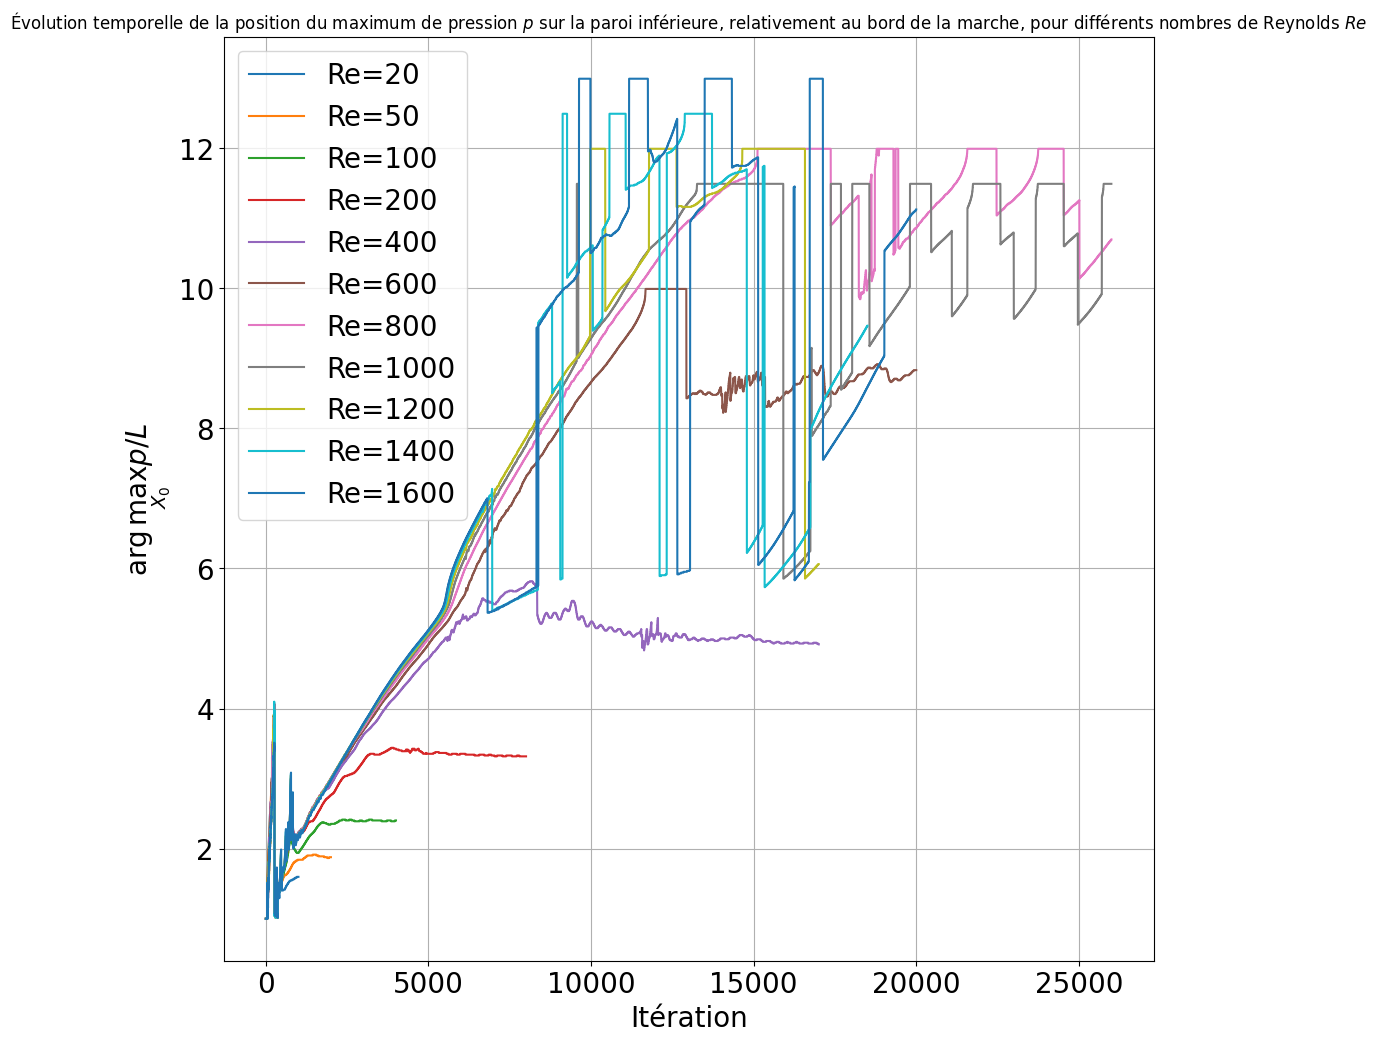

In [61]:
fig = plt.figure(figsize=(12, 12))

for Re in Re_range:
    max_p = np.load(f'./out/max_p_t-{Re}.npy')
    n_p = len(max_p)
    plt.plot(np.linspace(0, n_p-1, n_p), max_p, label=f'Re={Re}')

plt.title("Évolution temporelle de la position du maximum de pression $p$ sur la paroi inférieure, relativement au bord de la marche, pour différents nombres de Reynolds $Re$")
plt.xlabel('Itération', fontsize=fs)
plt.ylabel('$\\arg \\max_{X_0} p / L$', fontsize=fs)
plt.grid()
plt.legend(fontsize=fs)
plt.show()

_La position du maximum de pression est ici repérée à partir du bord de la marche descendante $X_0$._

D'après la figure 5 de Chiang et al [3], l'écoulement prend effectivement un certain temps pour développer ces bulles de recirculation. Après lancement de la simulation aux conditions initiales de profil parabolique, les bulles se forment progressivement de gauche à droite, or ce sont des zones de dépressions. L'augmentation de la position du maximum de pression $\arg \max_{X_0} p$ est donc lié à l'augmentation de la taille de la bulle primaire - celle collée à la marche descendante : tant que celle-ci n'est pas stabilisée, la dépression grossira et donc le maximum se décallera.

Trois états peuvent donc être définis à partir de cette observation :
- Un premier état de régime transitoire, pour lequel l'écoulement prend sa forme topologique perturbée par la marche descendante. Pendant cette phase, la position du maximum de pression augmente, à mesure du grossissement de la bulle primaire de recirculation. En termes de système dynamique, la position correspondant à la condition initiale est instable, l'état décrivant l'écoulement diverge car l'instabilité grossit.
- Un deuxième état de régime stationnaire, dans lequel la position du maximum n'évolue plus. On suppose alors l'entièreté de l'écoulement stationnaire, c'est-à-dire qu'il a atteint un état d'équilibre avec son ensemble de bulles de recirculation. La trajectoire de l'état décrivant l'écoulement a convergé vers un nouveau point fixe.
- Un troisième état de régime instationnaire, caractérisé par des fluctuations de la position du maximum de pression, et donc une fluctuation de la position des bulles. La trajectoire de l'écoulement dans l'espace des phases oscille

Ainsi, d'après la figure, les écoulements à Reynolds inférieur à $200$ sont stationnaires (en considérant les oscillations de la bulle de recirculation comme négligeables devant $H$). Le seuil d'instationnarité se situe entre $Re = 400$ et $Re = 600$ : en effet, pour $Re = 400$, des oscillations sont présentes mais encore faibles, mais pour $Re = 600$ celles-ci ne sont plus du tout négligeables. De plus, un déplacement brutal de la position du maximum de pression a lieu vers l'itération 12000, indiquant une fois de plus l'instationnarité de l'écoulement. Pour $Re \geq 600$, on observe ainsi un motif qui semble périodique, contenant de nombreuses fréquences. Le spectre ne semble cependant pas large bande, indiquant qu'un régime chaotique n'est pas encore établi : par exemple, les créneaux peuvent très bien être modélisés par une somme de modes de Fourier, donc discrets.

Cette instationnarité a par exemple été observée par Chiang _et al_ pour des simulations numériques à nombre de Reynolds élevé $Re = 2500$ [3]. Ils observent en effet des détachements tourbillonaires dans le canal à mesure que les bulles de recirculation se forment. De plus, ils remarquent que chaque bulle est initialement composée de petits tourbillons qui fusionnent progressivement entre eux, ce qui permet de stabiliser l'écoulement. Cela explique en partie le premier état de régime transitoire, plus ou moins long en fonction du nombre de Reynolds $Re$, qui permet notamment de réduire l'erreur (norme $L^2$ dans le cas de Chiang _et al_) de la simulation lorsque celle-ci est comparée à un écoulement de référence. La différence majeure avec la présente étude est que cette équipe constate une stabilisation de l'écoulement jusqu'au régime stationnaire, pouvant s'expliquer par le schéma de différences finies employé et la diffusion qui permettrait cette stabilisation.

# Influence de la hauteur du domaine

<b style="color:#0055FA">6. En partant de $L_y=2H$, étudier l'influence de la hauteur du domaine sur les grandeurs précédentes. (On prendra $L_y=3H$, $L_y=4H$ et $L_y=8H$)  </b>

## Simulations pour différentes valeurs de hauteur de domaine

In [9]:
H = 41
L = 2*H
ny_range = np.array([
    2*H,
    3*H,
    4*H,
    8*H
])

# Reynolds number is based on the total height ny of the domain, thus it needs to be adapted to get the same physical results
Re_range = 200 * ny_range / (2*H)

# Maillage/Domaine
x0,y0=L,H     # Coordonnées du bord de la marche
dx = 1./H
dt=dx*c0 / c0_real

In [ ]:
for i, ny_value in enumerate(ny_range):
    # Do not forget to set the value globally, so it is accessible to the simulation
    ny = ny_value
    nx = 6*ny_value
    simulate(Re=Re_range[i], nt=int(2500*ny_value/H), save_results=True, results_prefix='varying_ratio')

## Résultats

### Allure quantitative de l'écoulement

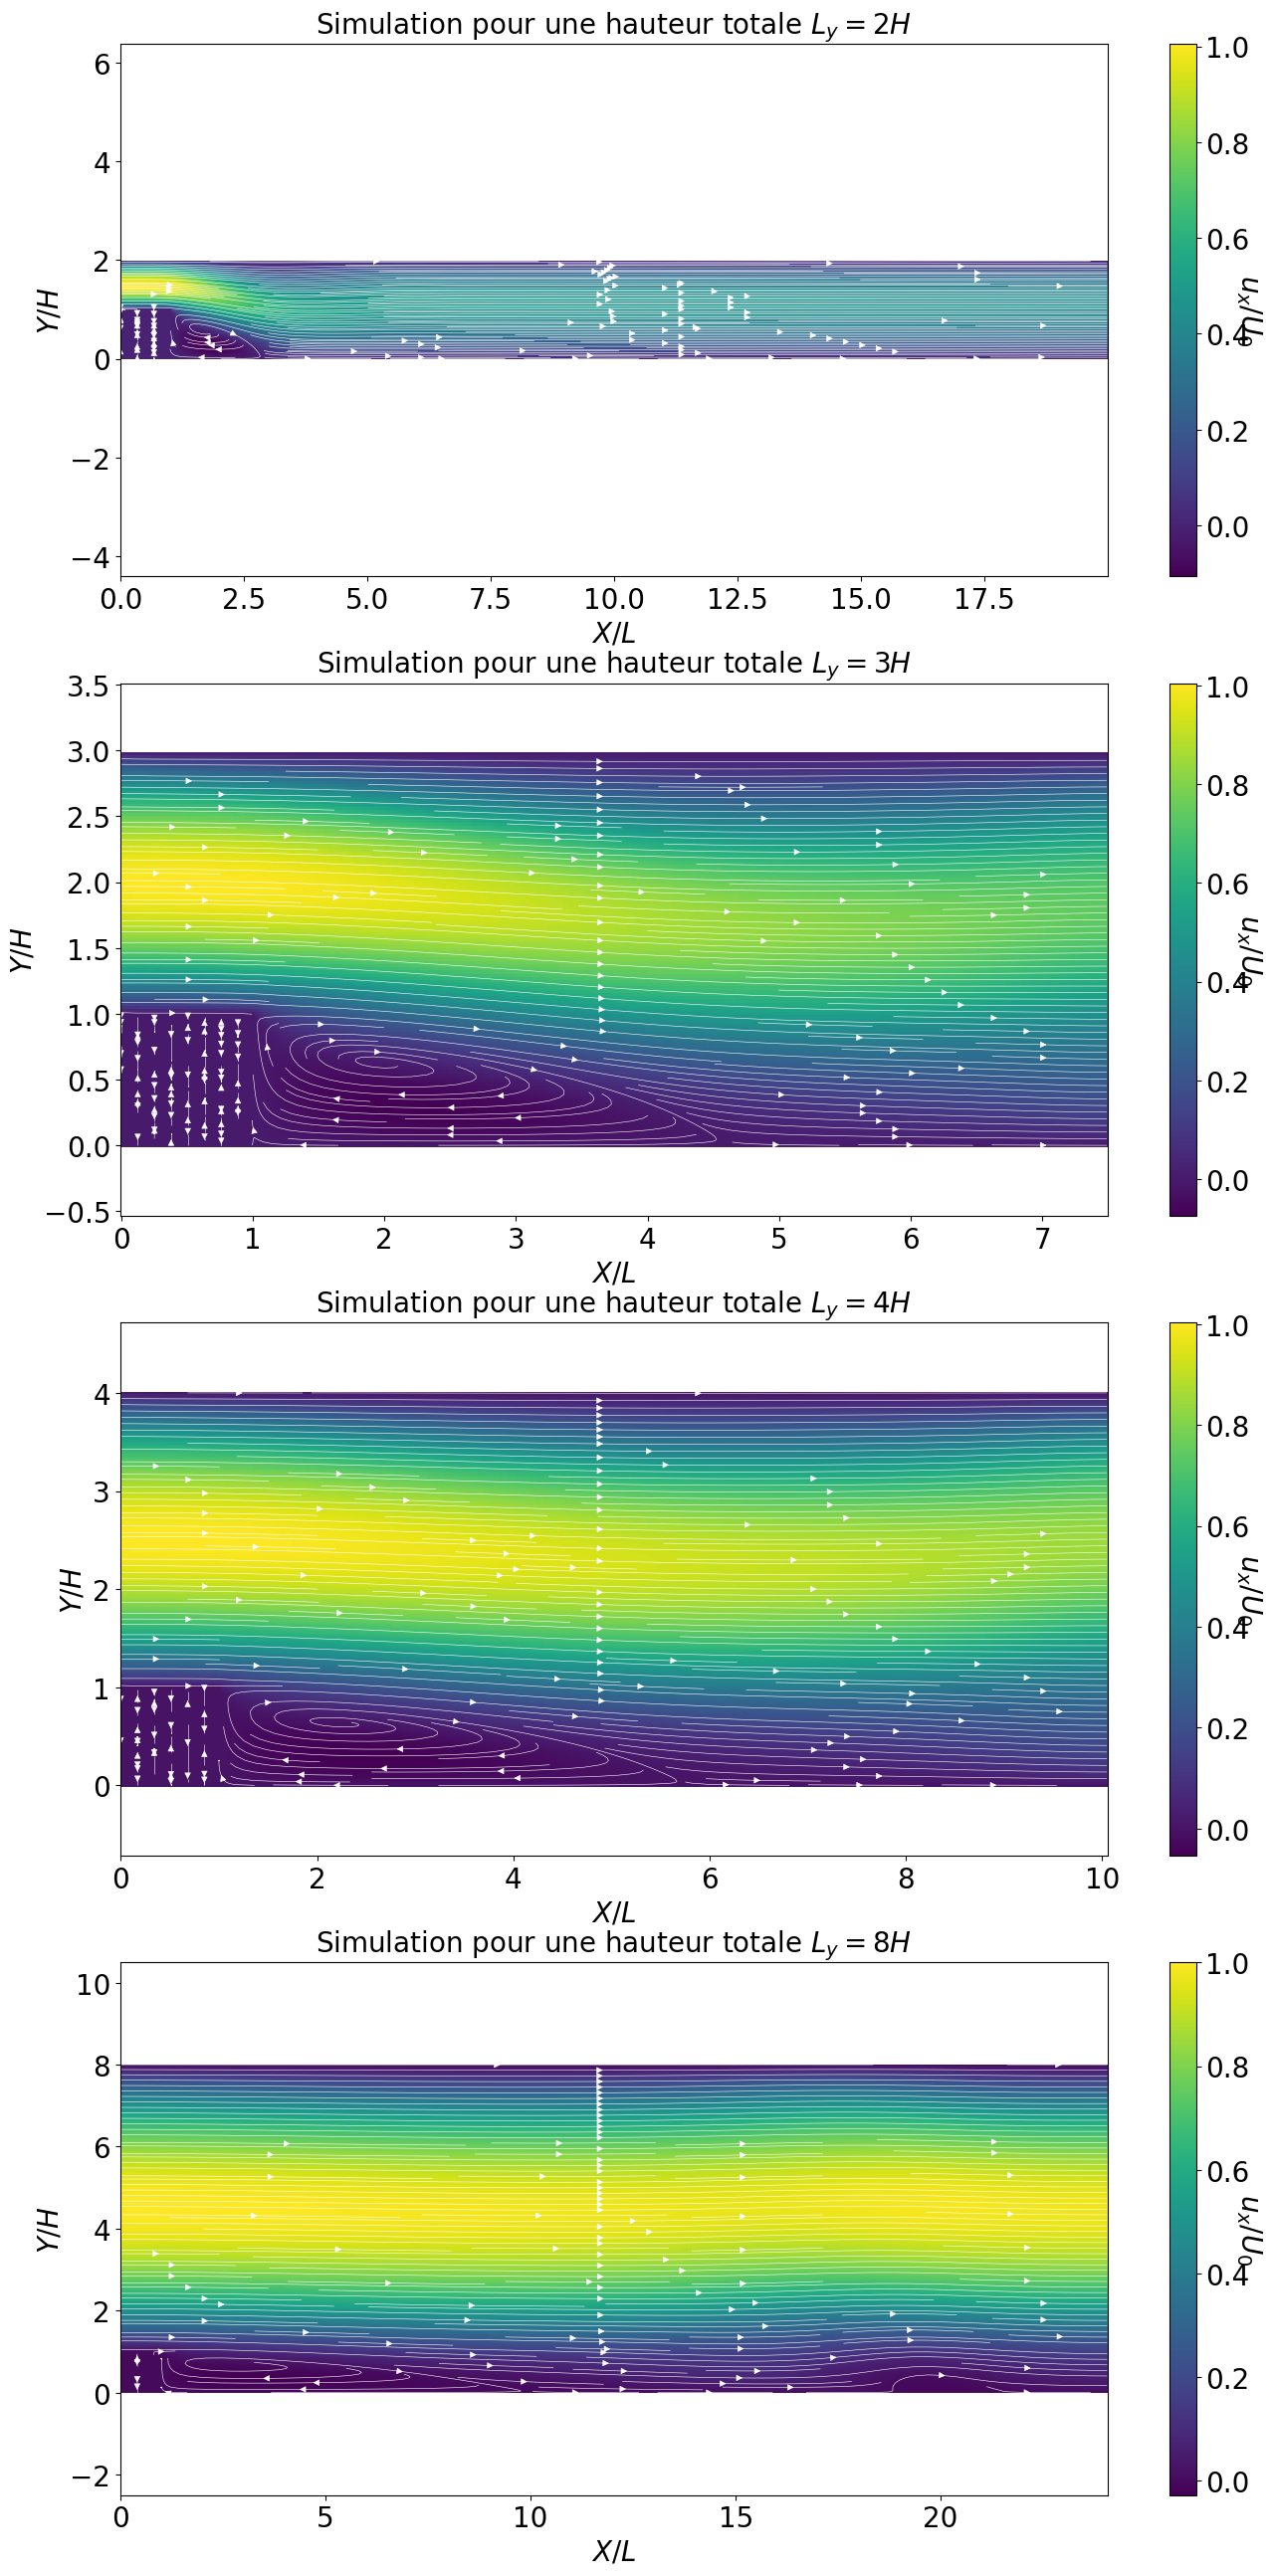

In [62]:
import os

uxes_files = [filename for filename in os.listdir('./out') if filename.startswith('varying_ratio-ux')]
uyes_files = [filename for filename in os.listdir('./out') if filename.startswith('varying_ratio-uy')]

fig, ax = plt.subplots(figsize=(16, 8*len(ny_range)), nrows=len(ny_range), ncols=1)

for i, ny in enumerate(ny_range):
    ux = np.load(f'./out/{uxes_files[i]}')
    uy = np.load(f'./out/{uyes_files[i]}')

    plt.sca(ax[i])
    plot_mesh(ux, uy)
    plt.title(f'Simulation pour une hauteur totale $L_y = {int(ny/H)}H$', fontsize=fs)

Lorsque la hauteur totale du domaine augmente sans changer la hauteur de la marche, on remarque un profil d'écoulement similaire en entrée et en sortie (paraboliques), cependant la bulle de recirculation évolue. Celle-ci est de plus en plus longue à mesure que le diamètre hydraulique est augmenté. Cela peut s'expliquer par la plus grande inertie du fluide lorsqu'il arrive au-dessus de la marche, au vu de la plus grande colonne alors formée. Il faut donc davantage de distance pour que cet écoulement recolle contre le bord inférieur.

Un résultat surprenant est l'apparition d'une bulle secondaire pour $L_y = 8H$, loin derrière la première ($X \approx 36H$), ce qui pourrait s'expliquer par le coefficient de pression, analysé plus tard dans cette étude.

### Longeur de recirculation

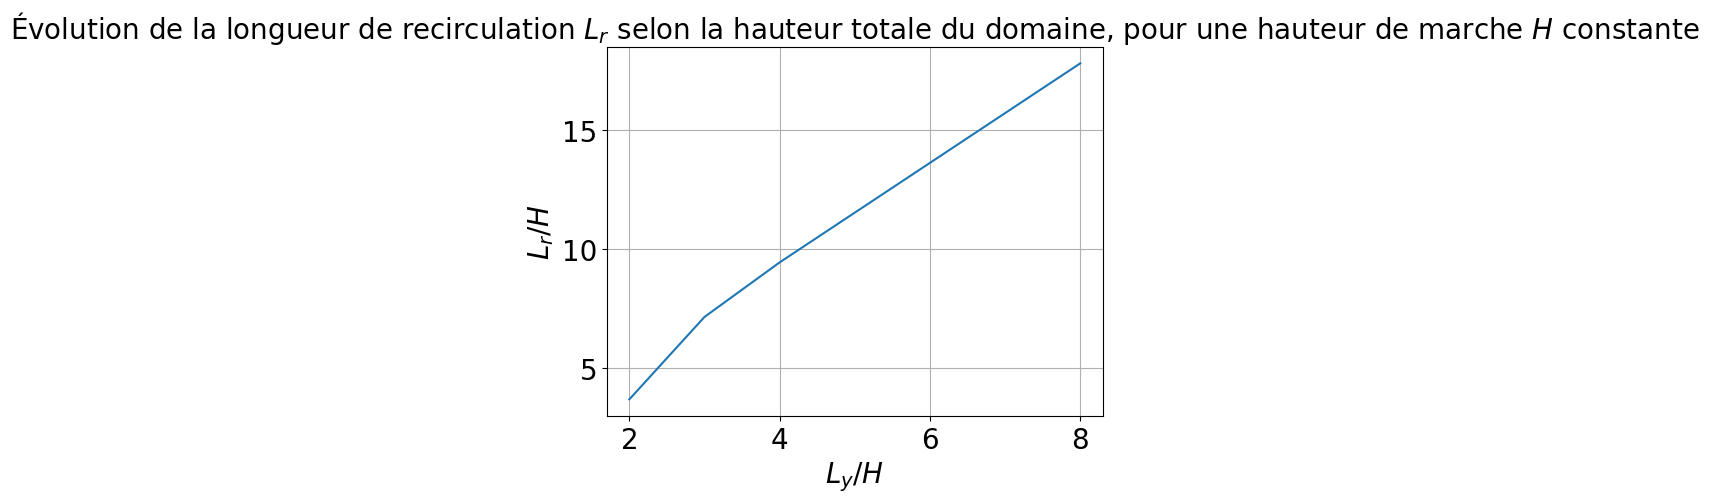

In [82]:
Lr_ny = np.zeros(len(ny_range))

for i, ny in enumerate(ny_range):
    ux = np.load(f'./out/{uxes_files[i]}')
    uy = np.load(f'./out/{uyes_files[i]}')

    sign_change_bottom, sign_change_top = get_recirculation_positions(ux)
    Lr_ny[i] = sign_change_bottom[0]

plt.plot((ny_range/H).astype('int'), Lr_ny)
plt.grid()
plt.xlabel('$L_y/H$', fontsize=fs); plt.ylabel('$L_r/H$', fontsize=fs)
plt.title('Évolution de la longueur de recirculation $L_r$ selon la hauteur totale du domaine, pour une hauteur de marche $H$ constante', fontsize=fs)
plt.show()

In [88]:
dx

0.024390243902439025

In [83]:
Lr_ny, Re_range

(array([ 3.68292683,  7.14634146,  9.43902439, 17.80487805]),
 array([200., 300., 400., 800.]))

L'intuition établie d'après le précédent graphique se retrouve ici confirmée quantitativement. La relation semble même linéaire pour cet espace de paramètres $L_y$.

Le calcul pour $L_y = 3H$ a également été effectué par Biswas _et al_ [4] : pour $Re_D = 100$, ceux-ci calculent une longueur de recirculation $L_r$ de $6.25$ contre $7.15$ dans la présente étude. Les résultats sont plutôt proches, les écarts pouvant s'expliquer par la résolution du maillage qui n'est pas optimale : $\Delta x = 0.024$ dans les présents travaux, contre $\Delta x = 0.01$ utilisé par Biswas _et al_.

### Coefficient de pression sur le bord inférieur

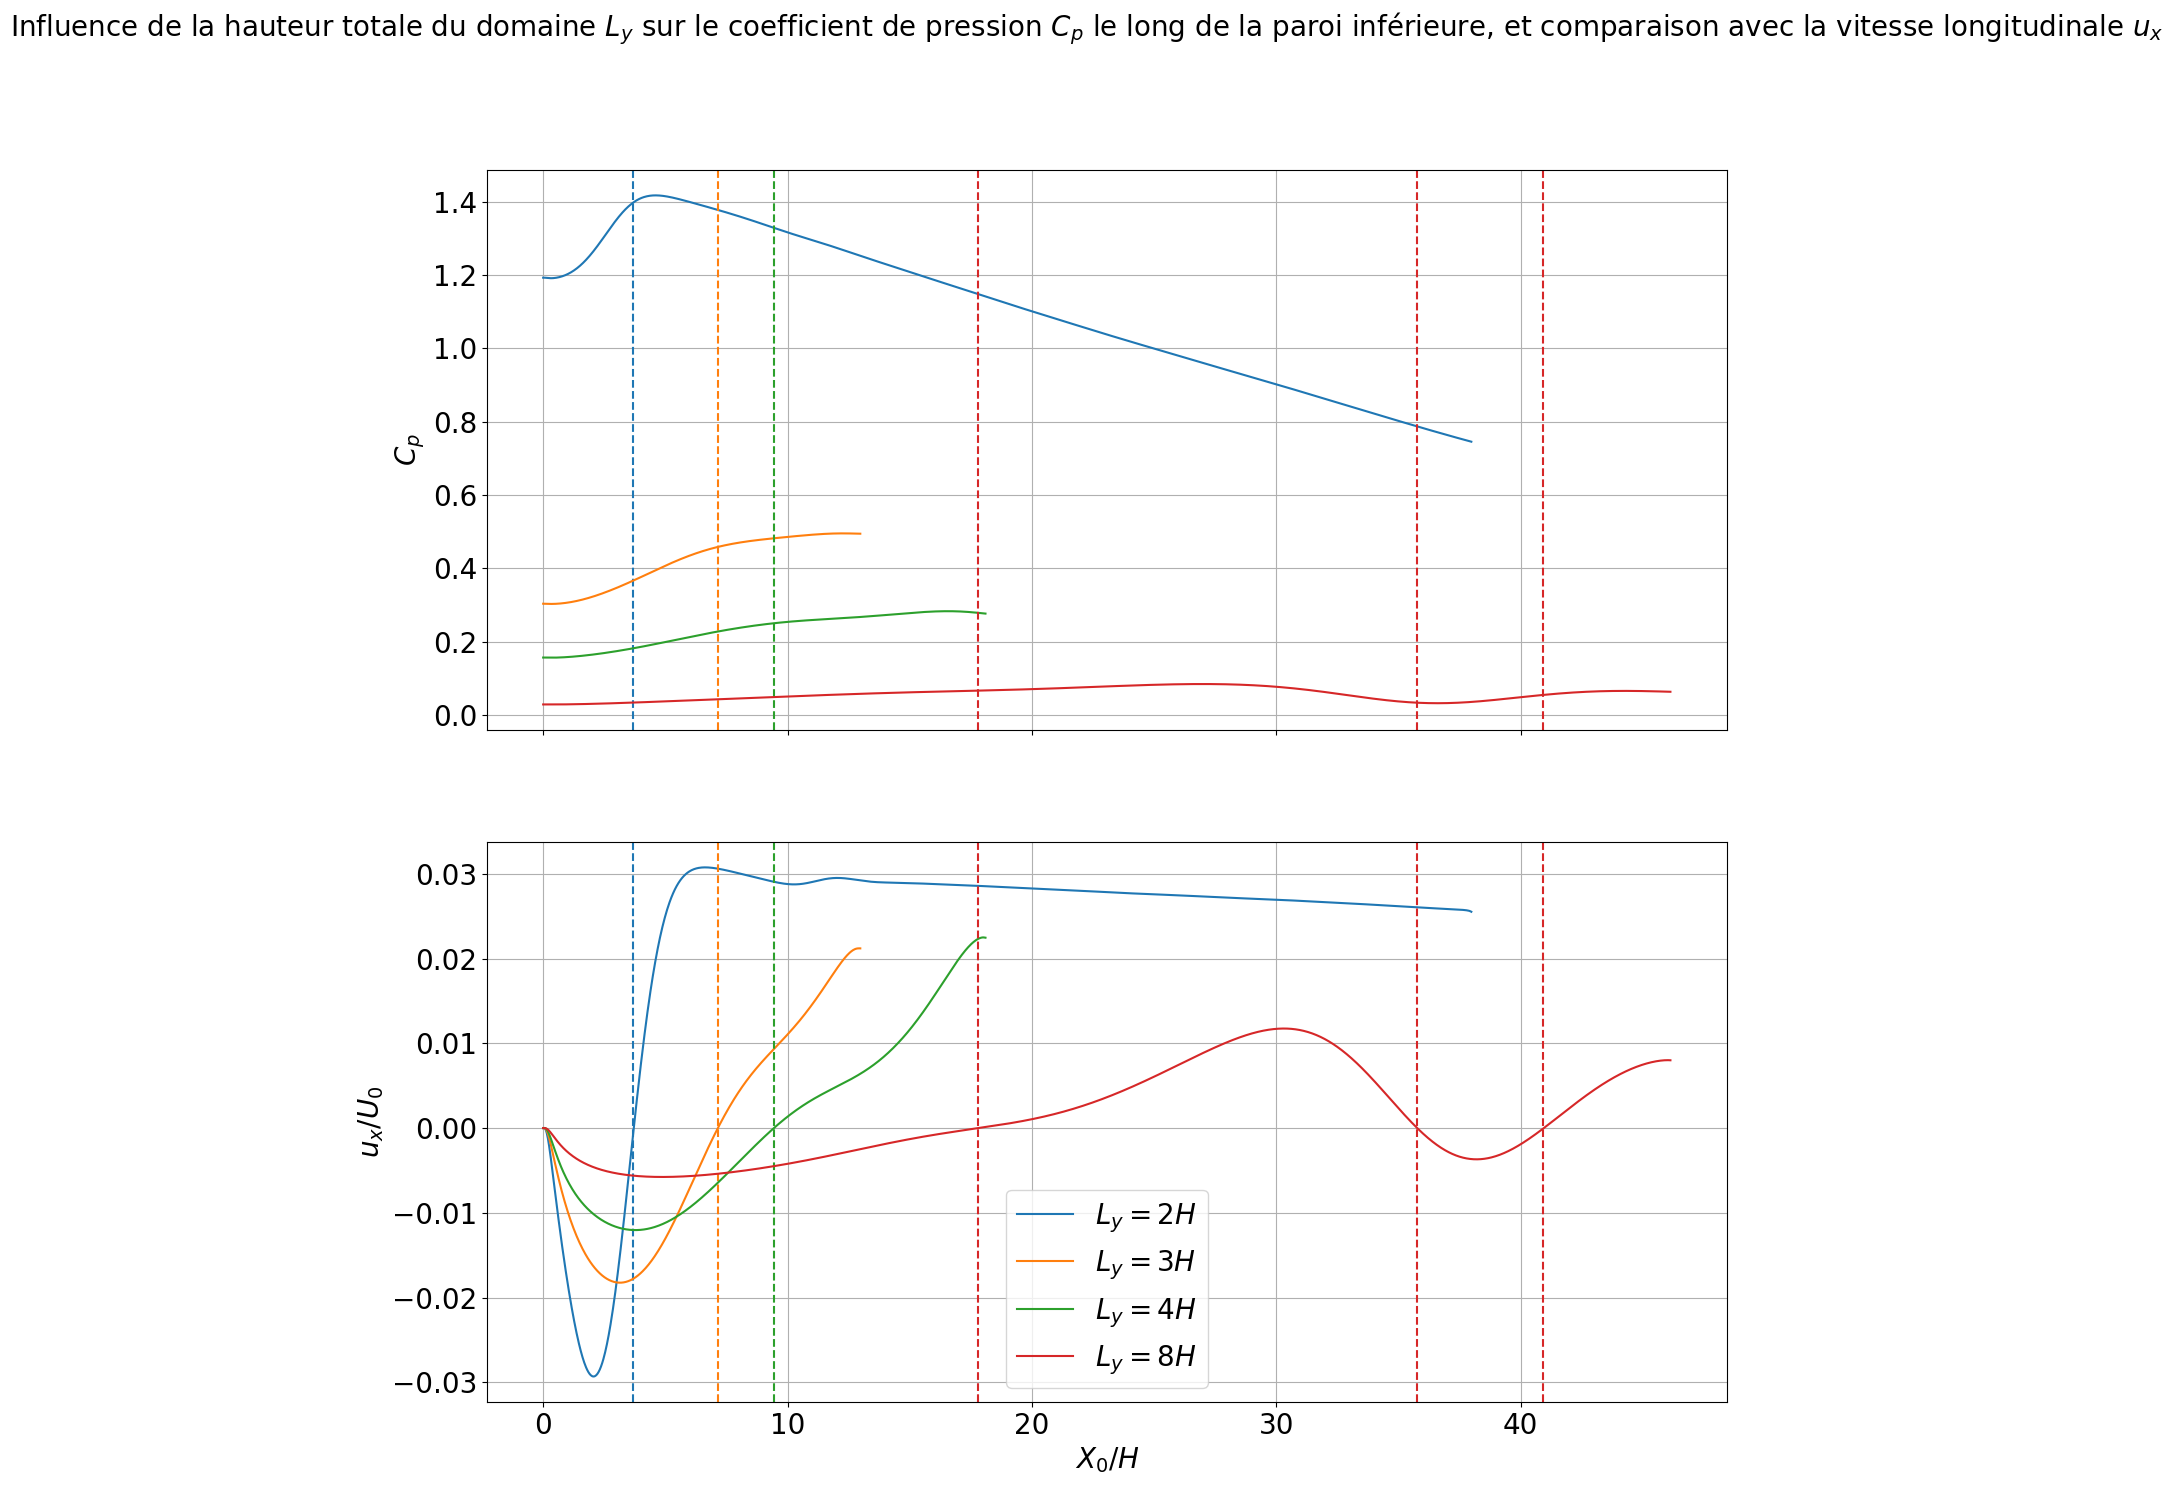

In [65]:
rho_files = [filename for filename in os.listdir('./out') if filename.startswith('varying_ratio-rho')]
ux_files = [filename for filename in os.listdir('./out') if filename.startswith('varying_ratio-ux')]

fig, (Cp_ax, ux_ax) = plt.subplots(figsize=(16, 16), nrows=2, ncols=1, sharex=True)
fig.suptitle('Influence de la hauteur totale du domaine $L_y$ sur le coefficient de pression $C_p$ le long de la paroi inférieure, et comparaison avec la vitesse longitudinale $u_x$', fontsize=fs)

for i, ny in enumerate(ny_range):
    rho = np.load(f'./out/{rho_files[i]}')
    ux = np.load(f'./out/{ux_files[i]}')
    rho0 = 1
    Cp = (rho - rho0) / (1/2 * rho0 * M0**2)
    n_p = len(Cp)
    x_lid = np.linspace(0, n_p - x0 - 1, n_p - x0)/H

    sign_change_bottom, _ = get_recirculation_positions(ux)
    u_lid = ux[L:, 1]
    Cp_lid = Cp[L:, 0]

    plt.sca(Cp_ax)
    plt.plot(x_lid, Cp_lid, label=f'$L_y = {int(ny/H)}H$')
    plt.ylabel('$C_p$',fontsize=fs)
    for pos in sign_change_bottom:
        plt.axvline(pos, color=colors[i], linestyle='dashed')
    Cp_ax.grid(True)

    plt.sca(ux_ax)
    plt.plot(x_lid, u_lid/U0, label=f'$L_y = {int(ny/H)}H$')
    plt.ylabel('$u_x/U_0$', fontsize=fs)
    for pos in sign_change_bottom:
        plt.axvline(pos, color=colors[i], linestyle='dashed')
    ux_ax.grid(True)

plt.xlabel('$X_0/H$',fontsize=fs)
plt.legend(fontsize=fs)
plt.show()

La pression le long du bord inférieur diminue lorsque la taille du domaine augmente. Cela peut directement se relier à la vitesse : en effet, un plus grand rayon de conduite engendre un profil parabolique davantage réparti, la vitesse adjacente à la paroi inférieure se voit donc diminuer par effet de moyenne (répartition de la quantité de mouvement sur toute la hauteur). Ainsi, par la loi de Bernoulli, une diminution de la vitesse dans les sections d'écoulement laminaire engendre une diminution quadratique de la pression, ce qui est bien observé sur le graphique.

Pour $L_y = 8H$, on observe bien une seconde dépression en aval de la marche descendante à $X_0 \approx 35H$ car la vitesse $u_x$ est négative, confirmant ainsi la bulle constatée qualitativement. Elle correspond d'ailleurs bien à une zone de dépression.

In [93]:
for i, ny in enumerate(ny_range):
    rho = np.load(f'./out/{rho_files[i]}')
    ux = np.load(f'./out/{ux_files[i]}')
    rho0 = 1
    Cp = (rho - rho0) / (1/2 * rho0 * M0**2)

    ux_min, x_min = np.min(ux[L:, 1]), np.argmin(ux[L:, 1])
    Cp_min = Cp[x_min, 1]
    print(f'ny={ny} | umin = {ux_min} | Cp at umin = {Cp_min}')

ny=82 | umin = -0.005076710886885416 | Cp at umin = 1.1927330779876892
ny=123 | umin = -0.003159989762837638 | Cp at umin = 0.307893768365217
ny=164 | umin = -0.002084923873367288 | Cp at umin = 0.16253218247137052
ny=328 | umin = -0.000999299213594849 | Cp at umin = 0.0317603930877455


Chaque doublement de la taille du domaine divise environ par deux la vitesse minimale dans la bulle de recirculation, engendrant une division du coefficient de presion d'un peu plus de 4. L'effet Bernoulli permet alors d'expliquer en partie le lien entre $u_x$ et $C_p$.

# Comparaison des résultats avec la littérature

<b style="color:#0055FA">7. A partir des références ci-dessous, comparer vos résultats à ceux de la littérature. Commenter et expliquer les différences observées. </b>

_Les comparaisons ont directement été effectuées dans les parties concernées pour une meilleure organisation._

<h2>Références pour confrontation des résultats:</h2>

- [1] <a href="https://courses.washington.edu/me431/handouts/armaly-jfm-83.pdf">Armaly et al. JFM 1983</a>
- [2] <a href="https://ntrs.nasa.gov/api/citations/19840004346/downloads/19840004346.pdf">Mansour et al. NASA-Tech. 1983</a>
- [3] <a href="https://www.sciencedirect.com/science/article/pii/S0307904X99000190">Chiang et al. J.Applied Math 1999</a>

- [4] <a href="https://www.researchgate.net/profile/Gautam-Biswas-10/publication/236866548_Backward-Facing_Step_Flows_for_Various_Expansion_Ratios_at_Low_and_Moderate_Reynolds_Numbers/links/0a85e52ff1a81e3608000000/Backward-Facing-Step-Flows-for-Various-Expansion-Ratios-at-Low-and-Moderate-Reynolds-Numbers.pdf?_tp=eyJjb250ZXh0Ijp7ImZpcnN0UGFnZSI6InB1YmxpY2F0aW9uIiwicGFnZSI6InB1YmxpY2F0aW9uIn19">Biswas et al. ASME 2004</a>


# Conclusion

L'objectif de ce projet était de mettre en oeuvre une méthode de Lattice-Boltzmann afin de résoudre le problème de la marche descendante dans un écoulement de fluide. Ce problème fait partie des nombreux écoulements de référence en mécanique des fluides, afin de tester des expériences ou des méthodes numériques et de vérifier les résultats avant de poursuivre dans des projets dérivés. Une large documentation existe, parmis laquelle 4 références ont été sélectionnées pour comparer les résultats de la présente étude.

La vitesse d'entrée à Mach 0,3 correspond à une valeur admissible pour le modèle D2Q9 sans obtenir de fortes erreurs, et les écoulements obtenus vérifient les prédictions expérimentales et numériques précédemment établies pour des nombres de Reynolds faibles ($Re < 400$). Au-delà, le manque de prise en compte des effets 3D provoque des écarts importants sur les grandeurs, bien que la physique du problème soit bien respectée. Le calcul exhibe notamment bien le comportement de bulles de recirculations se formant et évoluant à mesure que le nombre de Reynolds augmente, ainsi que la dynamique de la pression associée. La possibilité offerte par la méthode Lattice-Boltzmann de réaliser des calculs instationnaires est ici primordiale pour simuler des écoulements physiques au-delà des petits nombres de Reynolds $Re \geq 600$.

Les solutions exhibées afin d'améliorer les prédictions numériques incluent notamment :
- L'augmentation de la résolution spatiale du maillage, tout en trouvant une valeur optimale entre précision et temps de calcul en fonction du besoin final ;
- La conservation du troisième moment, donc utiliser un modèle type `D2Q27`, pourrait légèrement améliorer les prédictions à haut nombre de Reynolds ;
- La prise en compte de la turbulence, qui apparait pour $Re > 1200$ et qui n'est pas reflétée en utilisant un temps de relaxation basique dans l'opérateur de collision ;
- L'utilisation d'un modèle à trois dimensions, type `D3Q19`, pour prendre en compte les effets correspondants dès $Re = 400$.

<a id="top" style="float:right;" href="http://dynfluid.ensam.eu/"><img style="height:120px;" src="http://dynfluid.ensam.eu/uas/DYNFLUID/logoPrincipal/Logo-DynFluid-Web.png"/></a>
<a style="float:left;" href="http://www.cnam.fr//"><img style="height:120px;" src="https://upload.wikimedia.org/wikipedia/commons/4/45/Logo_ENSTA_Paris.jpg"></a>
<center><a href="#top">Retour en haut de la page</a></center>